# Import datasets

In [1]:
import numpy as np
import pandas as pd
import pickle

def load_dataset(dsname):
    metadata = pd.read_csv(f"/datasets/nicolas_facchinetti/processed_data/{dsname}/metadata_final.csv")
    x = pickle.load(open(f"/datasets/nicolas_facchinetti/processed_data/{dsname}/processed_data0.p", "rb" ))
    y = pickle.load(open(f"/datasets/nicolas_facchinetti/processed_data/{dsname}/processed_labels.p", "rb" ))
    return metadata, x, y

In [2]:
from sklearn.preprocessing import StandardScaler
def standardize(data):
    scaler = StandardScaler()
    n = data.shape
    return scaler.fit_transform(data.reshape(n[0],-1)).reshape(n)

In [3]:
datasets = ["emodb", "emovo", "ravdess"]
data = {}
for d in datasets:
    md, x, y = load_dataset(d)
    data[d] = {}
    data[d]["x"] = standardize(x)
    data[d]["y"] = y
    data[d]["metadata"] = md

In [4]:
data['emodb']['x'][0]

array([[[ 2.2283542 ],
        [ 2.2549677 ],
        [ 1.3384961 ],
        ...,
        [ 0.2934177 ],
        [ 0.2959142 ],
        [ 0.2968846 ]],

       [[ 2.0029902 ],
        [ 1.8643242 ],
        [ 0.7405172 ],
        ...,
        [ 0.2863425 ],
        [ 0.29190773],
        [ 0.29354027]],

       [[ 2.1267264 ],
        [ 1.9560615 ],
        [ 0.11358885],
        ...,
        [ 0.28053695],
        [ 0.2902726 ],
        [ 0.29522917]],

       ...,

       [[ 2.4182806 ],
        [ 2.261967  ],
        [-0.07332418],
        ...,
        [ 0.27592492],
        [ 0.28775936],
        [ 0.293304  ]],

       [[ 3.1633828 ],
        [ 2.8536127 ],
        [ 0.16795002],
        ...,
        [ 0.2791396 ],
        [ 0.29049823],
        [ 0.29429343]],

       [[ 2.491603  ],
        [ 2.32261   ],
        [ 0.6417349 ],
        ...,
        [ 0.27983078],
        [ 0.29081678],
        [ 0.295721  ]]], dtype=float32)

# Define architectures

In [5]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, LSTM, TimeDistributed, InputLayer, Reshape, BatchNormalization, Bidirectional

2023-01-03 11:33:52.063955: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Search the best architecture

In [6]:
def get_m():
    m = Sequential([
            InputLayer(input_shape=(261,128,1)),
            Reshape((9,29,128,1)),
            TimeDistributed(Conv2D(16, kernel_size=(5,5), activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(pool_size=(4,4), strides=2)),

            TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),
            TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
            TimeDistributed(Flatten()),
            
            LSTM(3, return_sequences=False, dropout=0.2),
            Dense(5, activation='softmax')
    ])
    return m

get_m().summary()

2023-01-03 11:33:53.070500: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-03 11:33:53.071331: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-03 11:33:53.178868: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:15:00.0 name: NVIDIA TITAN V computeCapability: 7.0
coreClock: 1.455GHz coreCount: 80 deviceMemorySize: 11.77GiB deviceMemoryBandwidth: 607.97GiB/s
2023-01-03 11:33:53.178941: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-01-03 11:33:53.183227: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-01-03 11:33:53.183352: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-0

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 9, 29, 128, 1)     0         
_________________________________________________________________
time_distributed (TimeDistri (None, 9, 25, 124, 16)    416       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 9, 25, 124, 16)    64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 9, 11, 61, 16)     0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 9, 9, 59, 32)      4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 9, 4, 29, 32)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 9, 2, 27, 64)      1

In [7]:
def get_m1():
    m = Sequential([
            InputLayer(input_shape=(261,128,1)),
            Reshape((9,29,128,1)),
            TimeDistributed(Conv2D(16, kernel_size=(5,5), activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(pool_size=(4,4), strides=2)),

            TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),

            TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
            TimeDistributed(Flatten()),

            Bidirectional(LSTM(3, dropout=0.2, return_sequences=False)),
            Dense(5, activation='softmax')
    ])
    return m

get_m1().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 9, 29, 128, 1)     0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 9, 25, 124, 16)    416       
_________________________________________________________________
time_distributed_9 (TimeDist (None, 9, 25, 124, 16)    64        
_________________________________________________________________
time_distributed_10 (TimeDis (None, 9, 11, 61, 16)     0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 9, 9, 59, 32)      4640      
_________________________________________________________________
time_distributed_12 (TimeDis (None, 9, 4, 29, 32)      0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 9, 2, 27, 64)     

In [8]:
def get_m2():
    m = Sequential([
            InputLayer(input_shape=(261,128,1)),
            Reshape((9,29,128,1)),
            TimeDistributed(Conv2D(16, kernel_size=(5,5), activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(pool_size=(4,4), strides=2)),

            TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),
            TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
            TimeDistributed(Flatten()),
            
            LSTM(6, return_sequences=False, dropout=0.2),
            Dense(5, activation='softmax')
        ])
    return m

get_m2().summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 9, 29, 128, 1)     0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 9, 25, 124, 16)    416       
_________________________________________________________________
time_distributed_17 (TimeDis (None, 9, 25, 124, 16)    64        
_________________________________________________________________
time_distributed_18 (TimeDis (None, 9, 11, 61, 16)     0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 9, 9, 59, 32)      4640      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 9, 4, 29, 32)      0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, 9, 2, 27, 64)     

In [9]:
def get_m3():
    m = Sequential([
            InputLayer(input_shape=(261,128,1)),
            Reshape((9,29,128,1)),
            TimeDistributed(Conv2D(16, kernel_size=(3,3), activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),

            TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),
            TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
            TimeDistributed(Flatten()),
            
            LSTM(3, return_sequences=False, dropout=0.2),
            Dense(5, activation='softmax')
    ])
    return m

get_m3().summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 9, 29, 128, 1)     0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, 9, 27, 126, 16)    160       
_________________________________________________________________
time_distributed_25 (TimeDis (None, 9, 27, 126, 16)    64        
_________________________________________________________________
time_distributed_26 (TimeDis (None, 9, 13, 63, 16)     0         
_________________________________________________________________
time_distributed_27 (TimeDis (None, 9, 11, 61, 32)     4640      
_________________________________________________________________
time_distributed_28 (TimeDis (None, 9, 5, 30, 32)      0         
_________________________________________________________________
time_distributed_29 (TimeDis (None, 9, 3, 28, 64)     

In [10]:
def get_m4():
    m = Sequential([
            InputLayer(input_shape=(261,128,1)),
            Reshape((9,29,128,1)),
            TimeDistributed(Conv2D(16, kernel_size=(5,5), activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),

            TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),
            TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
            TimeDistributed(Flatten()),
            
            LSTM(6, return_sequences=False, dropout=0.2),
            Dense(5, activation='softmax')
    ])
    return m

get_m4().summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 9, 29, 128, 1)     0         
_________________________________________________________________
time_distributed_32 (TimeDis (None, 9, 25, 124, 16)    416       
_________________________________________________________________
time_distributed_33 (TimeDis (None, 9, 25, 124, 16)    64        
_________________________________________________________________
time_distributed_34 (TimeDis (None, 9, 12, 62, 16)     0         
_________________________________________________________________
time_distributed_35 (TimeDis (None, 9, 10, 60, 32)     4640      
_________________________________________________________________
time_distributed_36 (TimeDis (None, 9, 5, 30, 32)      0         
_________________________________________________________________
time_distributed_37 (TimeDis (None, 9, 3, 28, 64)     

In [11]:
def get_m5():
    m = Sequential([
            InputLayer(input_shape=(261,128,1)),
            Reshape((9,29,128,1)),
            TimeDistributed(Conv2D(32, kernel_size=(5,5), activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(pool_size=(4,4), strides=2)),

            TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),
            TimeDistributed(Conv2D(128, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
            TimeDistributed(Flatten()),
            
            LSTM(3, return_sequences=False, dropout=0.2),
            Dense(5, activation='softmax')
    ])
    return m

get_m5().summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 9, 29, 128, 1)     0         
_________________________________________________________________
time_distributed_40 (TimeDis (None, 9, 25, 124, 32)    832       
_________________________________________________________________
time_distributed_41 (TimeDis (None, 9, 25, 124, 32)    128       
_________________________________________________________________
time_distributed_42 (TimeDis (None, 9, 11, 61, 32)     0         
_________________________________________________________________
time_distributed_43 (TimeDis (None, 9, 9, 59, 64)      18496     
_________________________________________________________________
time_distributed_44 (TimeDis (None, 9, 4, 29, 64)      0         
_________________________________________________________________
time_distributed_45 (TimeDis (None, 9, 2, 27, 128)    

In [12]:
def get_m6():
    m = Sequential([
            InputLayer(input_shape=(261,128,1)),
            Reshape((9,29,128,1)),
            TimeDistributed(Conv2D(16, kernel_size=(5,5), activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),

            TimeDistributed(Conv2D(32, kernel_size=(5,5), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),

            TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
        
            TimeDistributed(Conv2D(128, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
            TimeDistributed(Flatten()),

            LSTM(3, dropout=0.2, return_sequences=False),
            Dense(5, activation='softmax')
    ])
    return m

get_m6().summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 9, 29, 128, 1)     0         
_________________________________________________________________
time_distributed_48 (TimeDis (None, 9, 25, 124, 16)    416       
_________________________________________________________________
time_distributed_49 (TimeDis (None, 9, 25, 124, 16)    64        
_________________________________________________________________
time_distributed_50 (TimeDis (None, 9, 12, 62, 16)     0         
_________________________________________________________________
time_distributed_51 (TimeDis (None, 9, 8, 58, 32)      12832     
_________________________________________________________________
time_distributed_52 (TimeDis (None, 9, 7, 57, 32)      0         
_________________________________________________________________
time_distributed_53 (TimeDis (None, 9, 5, 55, 64)     

In [13]:
archs = [get_m, get_m1, get_m2, get_m3, get_m4, get_m5, get_m6]

# Search best architecturs for all datasets

In [14]:
def train_evaluate(model_fn, train, val, test, opt='adam'):
    m = model_fn()
    m.compile(loss='categorical_crossentropy', optimizer=opt, metrics='accuracy')
    
    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min', restore_best_weights=True)
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, verbose=0, min_delta=1e-4, mode='min')

    # fit & predict
    history = m.fit(train[0], train[1],
                    epochs=50,
                    batch_size=32,
                    callbacks=[earlyStopping, reduce_lr_loss],
                    validation_data=(val[0], val[1]),
                    verbose=0)
    # test
    results = m.evaluate(test[0], test[1], batch_size=32, verbose=0)
    print("\t\tTest loss, test acc:", results)
    return history, results

In [15]:
from sklearn.model_selection import train_test_split

def train_test_kfold(model_fn, x, y, metadata, n=[1997,1941,1965]):    
    results = []
    
    train_df, test_df = train_test_split(metadata, 
                                   test_size = 0.2, 
                                   random_state = 2022,
                                   stratify = metadata['label'])
    test_index = test_df.index
    x_test = x[test_index]
    y_test = y[test_index]
  
    
    for num, rs in enumerate(n):
        trainK_df, val_df = train_test_split(train_df, 
                                   test_size = 0.2, 
                                   random_state = rs,
                                   stratify = train_df['label'])
        train_index = trainK_df.index
        val_index = val_df.index
        x_train = x[train_index]
        y_train = y[train_index]
        x_val = x[val_index]
        y_val = y[val_index]
        
        print(f"\t\tFold {num+1}")
        results.append(train_evaluate(model_fn, (x_train, y_train), (x_val, y_val), (x_test, y_test)))
    return results

In [16]:
from sklearn.model_selection import cross_val_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

results_arch = {}
for count, a in enumerate(archs):
    print(f'Architecture {count} of {len(archs)-1}')
    results_arch[f"m{count}"] = {}
    for d in data:
        print(f"\tTraining on {d}")
        x = data[d]["x"]
        y = data[d]["y"]
        metadata = data[d]["metadata"]
        res = train_test_kfold(a, x, y, metadata)
        results_arch[f"m{count}"][d] = res

Architecture 0 of 6
	Training on emodb
		Fold 1


2023-01-03 11:33:56.051794: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-01-03 11:33:56.066293: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3301490000 Hz
2023-01-03 11:33:57.068563: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-01-03 11:33:57.265981: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


		Test loss, test acc: [0.728945255279541, 0.7168458700180054]
		Fold 2
		Test loss, test acc: [0.8988902568817139, 0.6391875743865967]
		Fold 3
		Test loss, test acc: [0.7104760408401489, 0.7634408473968506]
	Training on emovo
		Fold 1
		Test loss, test acc: [1.0688490867614746, 0.6119554042816162]
		Fold 2
		Test loss, test acc: [1.0295628309249878, 0.5967578291893005]
		Fold 3
		Test loss, test acc: [1.1653344631195068, 0.5511651635169983]
	Training on ravdess
		Fold 1
		Test loss, test acc: [1.0683461427688599, 0.6152986884117126]
		Fold 2
		Test loss, test acc: [1.4457876682281494, 0.3757677376270294]
		Fold 3
		Test loss, test acc: [1.0580415725708008, 0.5946398377418518]
Architecture 1 of 6
	Training on emodb
		Fold 1
		Test loss, test acc: [0.4913940727710724, 0.8303464651107788]
		Fold 2
		Test loss, test acc: [0.45695579051971436, 0.8255674839019775]
		Fold 3
		Test loss, test acc: [0.48429110646247864, 0.8351254463195801]
	Training on emovo
		Fold 1
		Test loss, test acc: [0

In [24]:
res_mean = []
res_std = []

for a in results_arch:
    print(a)
    means = []
    stds = []
    for d in results_arch[a]:
        print(d)
        m = np.mean([p[1][1] for p in results_arch[a][d]])
        s = np.std([p[1][1] for p in results_arch[a][d]])
        print(f'\tmean: {m}')
        print(f'\tstd: {s}')
        means.append(m)
        stds.append(s)
    # compute mean of accuracy and std over three datasets
    means.append(np.mean(means))
    stds.append(np.mean(stds))
    
    res_std.append(stds)
    res_mean.append(means)
    print()

m0
emodb
	mean: 0.7064914306004842
	std: 0.05125186029260148
emovo
	mean: 0.586626132329305
	std: 0.025830883376327985
ravdess
	mean: 0.5285687545935313
	std: 0.10837530505069808

m1
emodb
	mean: 0.8303464651107788
	std: 0.0039020218173040876
emovo
	mean: 0.6990881363550822
	std: 0.025470717822890808
ravdess
	mean: 0.756932814915975
	std: 0.012201584180395

m2
emodb
	mean: 0.7789725065231323
	std: 0.007984832492070002
emovo
	mean: 0.6815265019734701
	std: 0.029391652443055073
ravdess
	mean: 0.6981202165285746
	std: 0.02443296853305064

m3
emodb
	mean: 0.680207093556722
	std: 0.04803137087970799
emovo
	mean: 0.3853427867094676
	std: 0.13875225051581921
ravdess
	mean: 0.3923320174217224
	std: 0.12557421892268714

m4
emodb
	mean: 0.7622461120287577
	std: 0.009755030209776003
emovo
	mean: 0.6609253684679667
	std: 0.028154912790801248
ravdess
	mean: 0.44928346077601117
	std: 0.15385100584269285

m5
emodb
	mean: 0.581839919090271
	std: 0.0508666992097439
emovo
	mean: 0.25160418450832367
	std

In [25]:
pd.DataFrame(res_mean, columns=['emodb', 'emovo', 'ravdess', 'mean'], index=['m0', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6'])

emodb     emovo   ravdess      mean
m0  0.706491  0.586626  0.528569  0.607229
m1  0.830346  0.699088  0.756933  0.762122
m2  0.778973  0.681527  0.698120  0.719540
m3  0.680207  0.385343  0.392332  0.485961
m4  0.762246  0.660925  0.449283  0.624152
m5  0.581840  0.251604  0.258515  0.363986
m6  0.315014  0.239784  0.231156  0.261985

In [26]:
pd.DataFrame(res_std, columns=['emodb', 'emovo', 'ravdess', 'mean'], index=['m0', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6'])

emodb     emovo   ravdess      mean
m0  0.051252  0.025831  0.108375  0.061819
m1  0.003902  0.025471  0.012202  0.013858
m2  0.007985  0.029392  0.024433  0.020603
m3  0.048031  0.138752  0.125574  0.104119
m4  0.009755  0.028155  0.153851  0.063920
m5  0.050867  0.025649  0.037574  0.038030
m6  0.058574  0.028179  0.034743  0.040499

In [19]:
import matplotlib.pyplot as plt

def plot_res_acc(h, x, y):
    plt.subplot(x, 2, y)
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_res_loss(h, x, y):
    plt.subplot(x, 2, y)
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_stats(h):
    fig = plt.gcf()
    fig.set_size_inches(15, 15)
    for num, c in enumerate(h):
        n = (num+1)*2
        plot_res_acc(c, len(h), n-1)
        plot_res_loss(c, len(h), n)
    plt.show()

m0
emodb


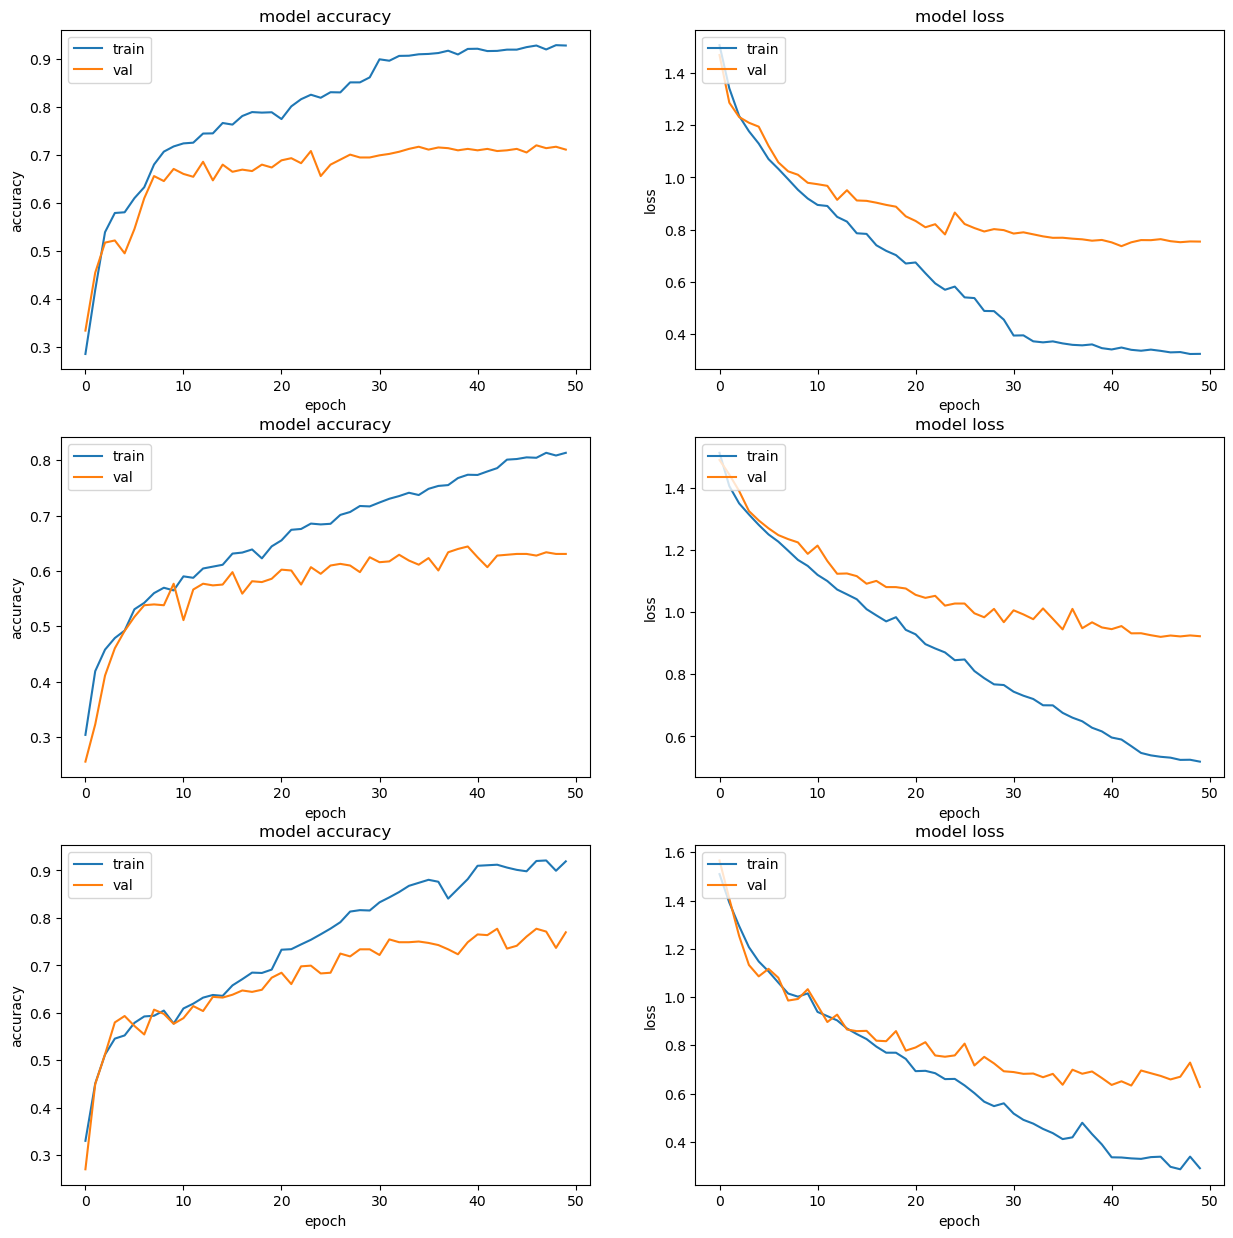

emovo


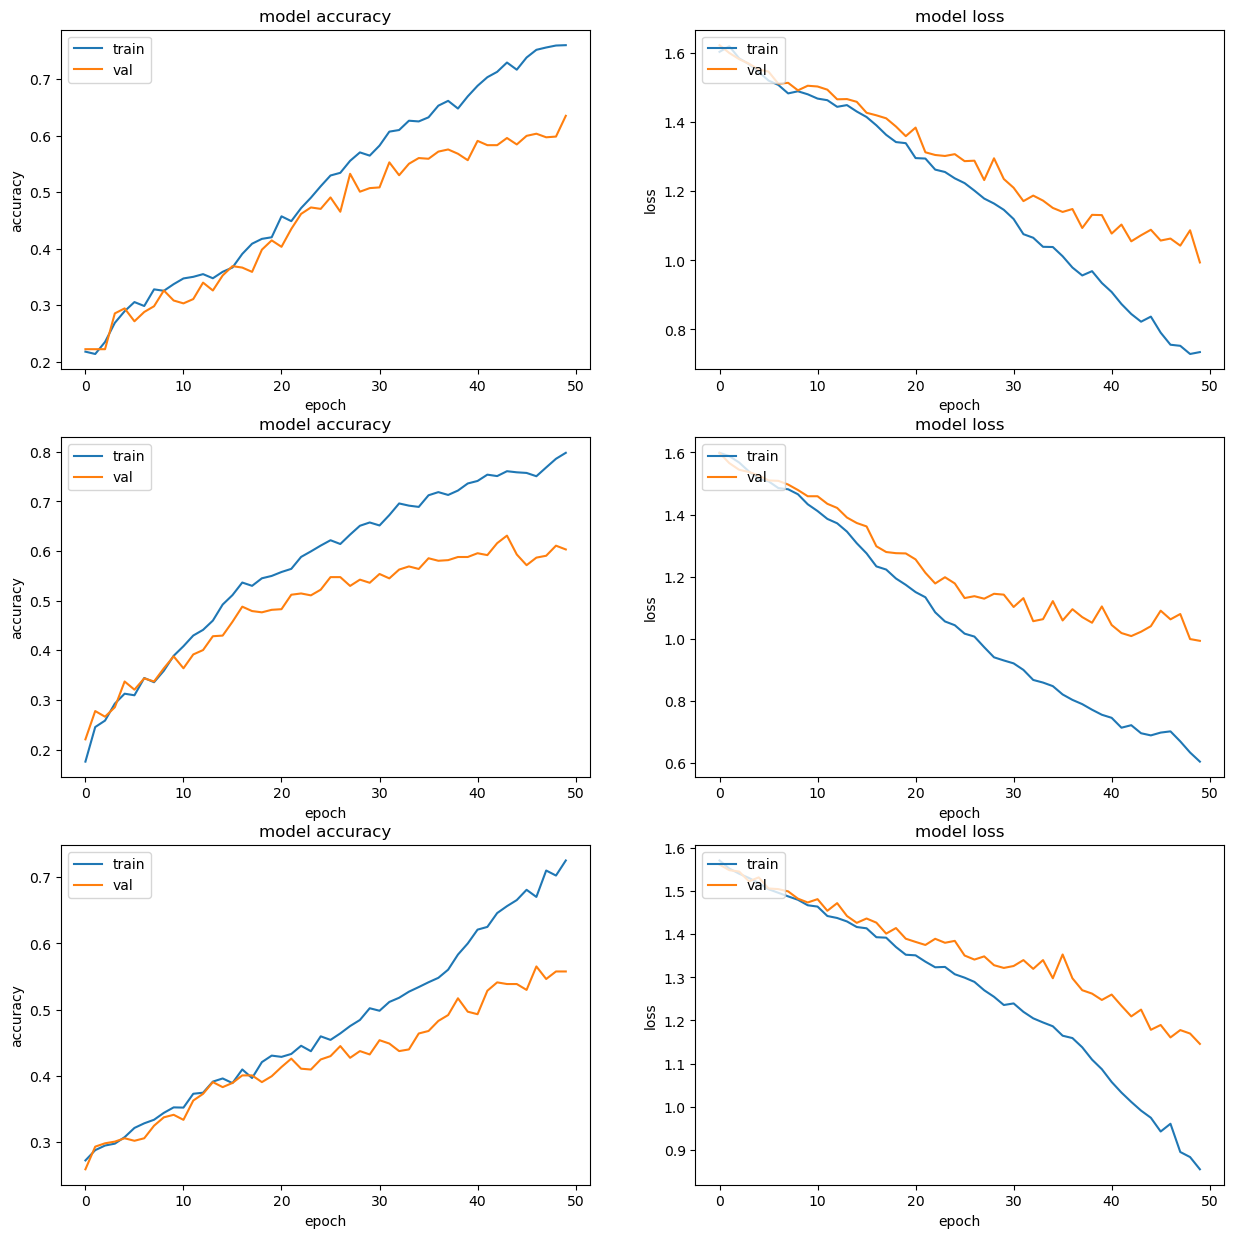

ravdess


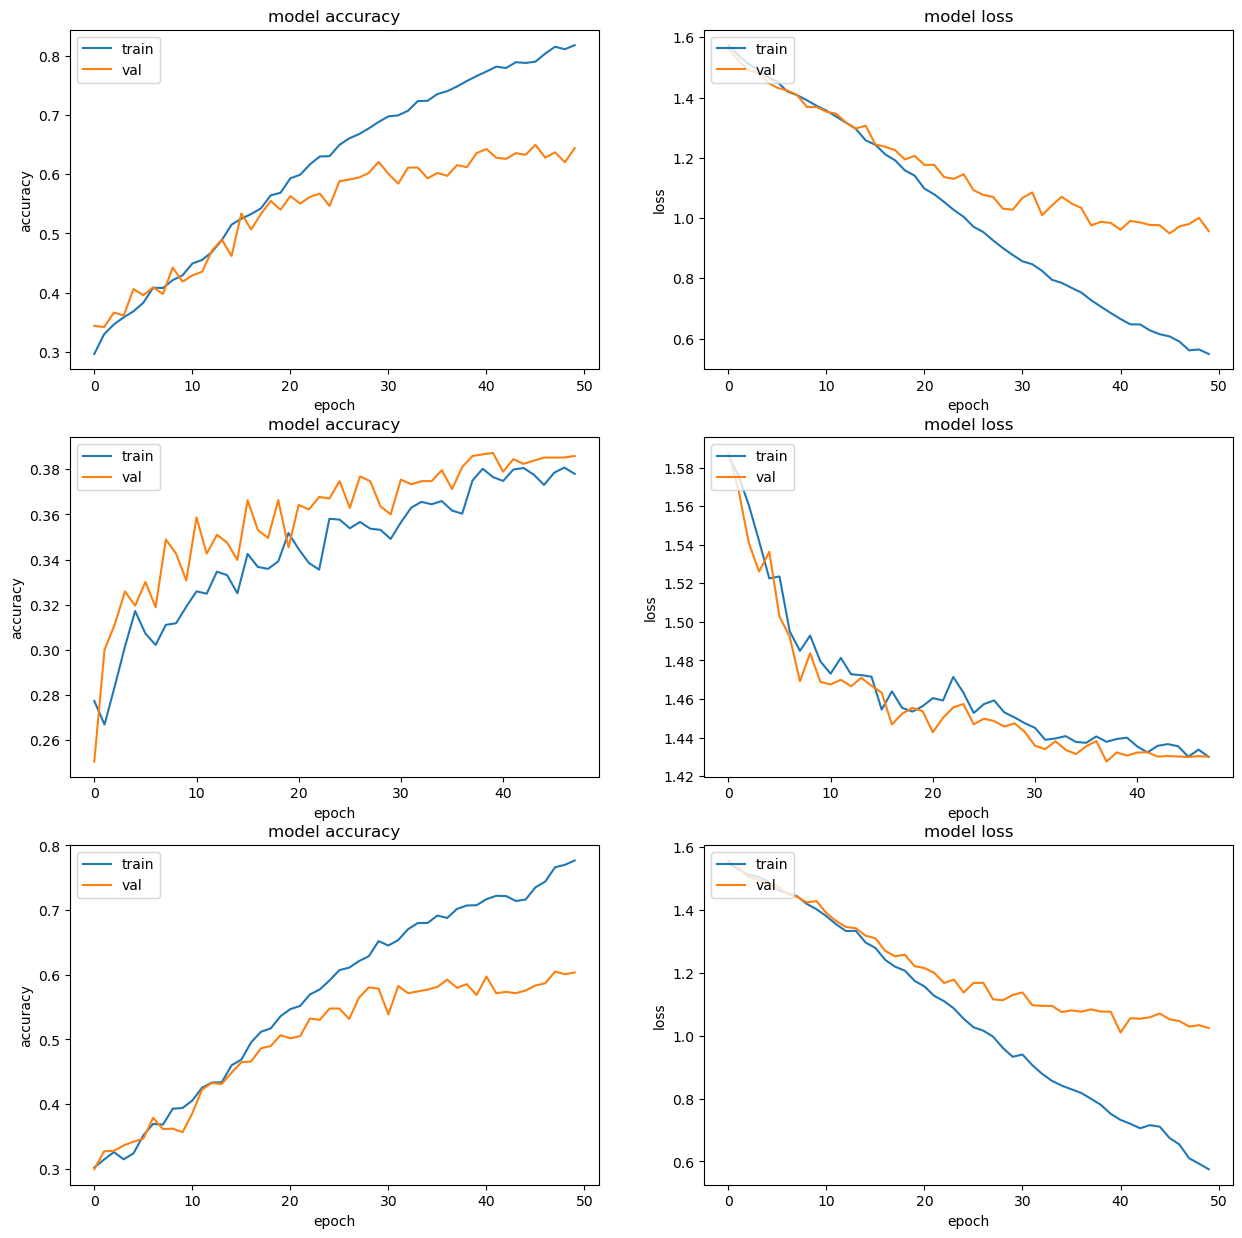


m1
emodb


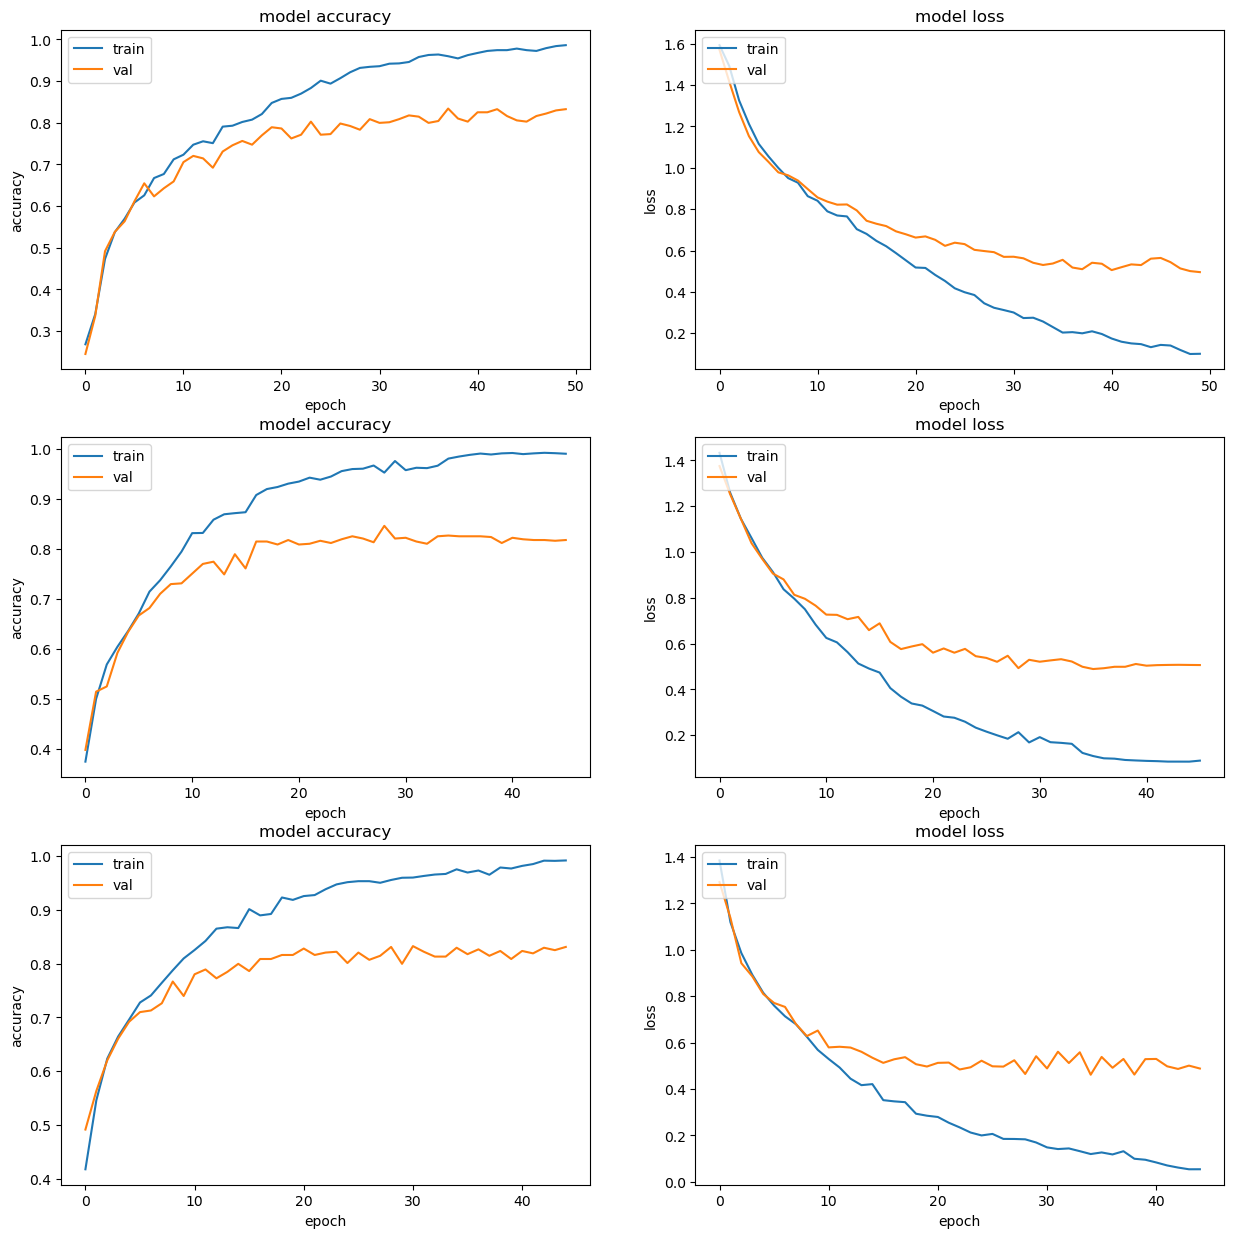

emovo


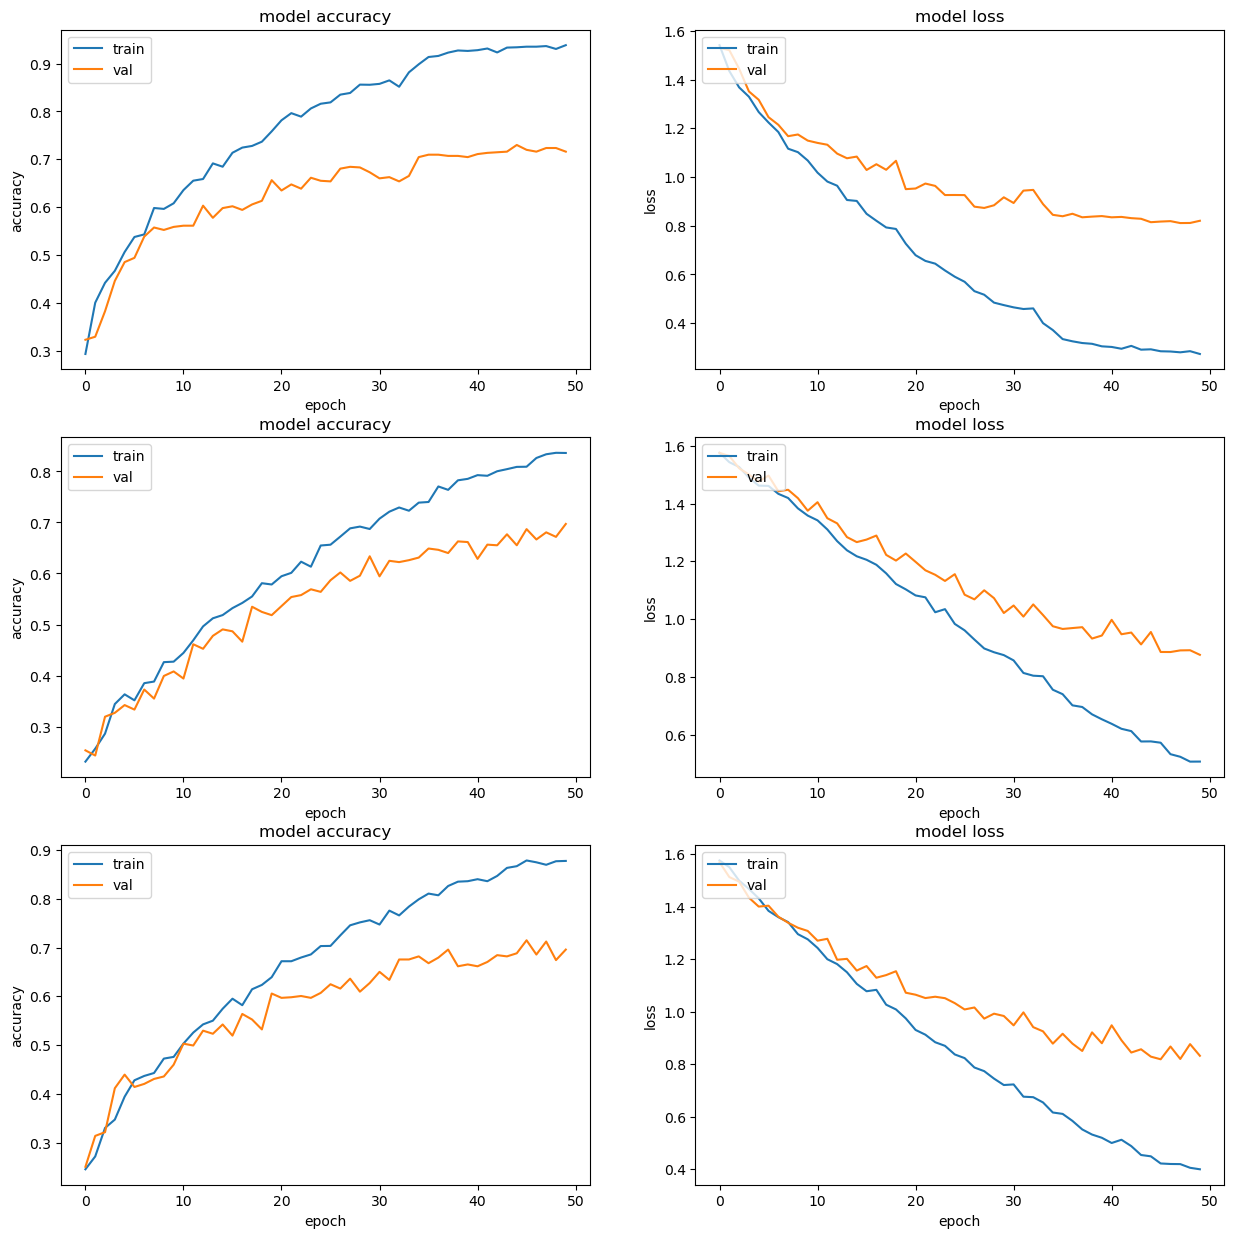

ravdess


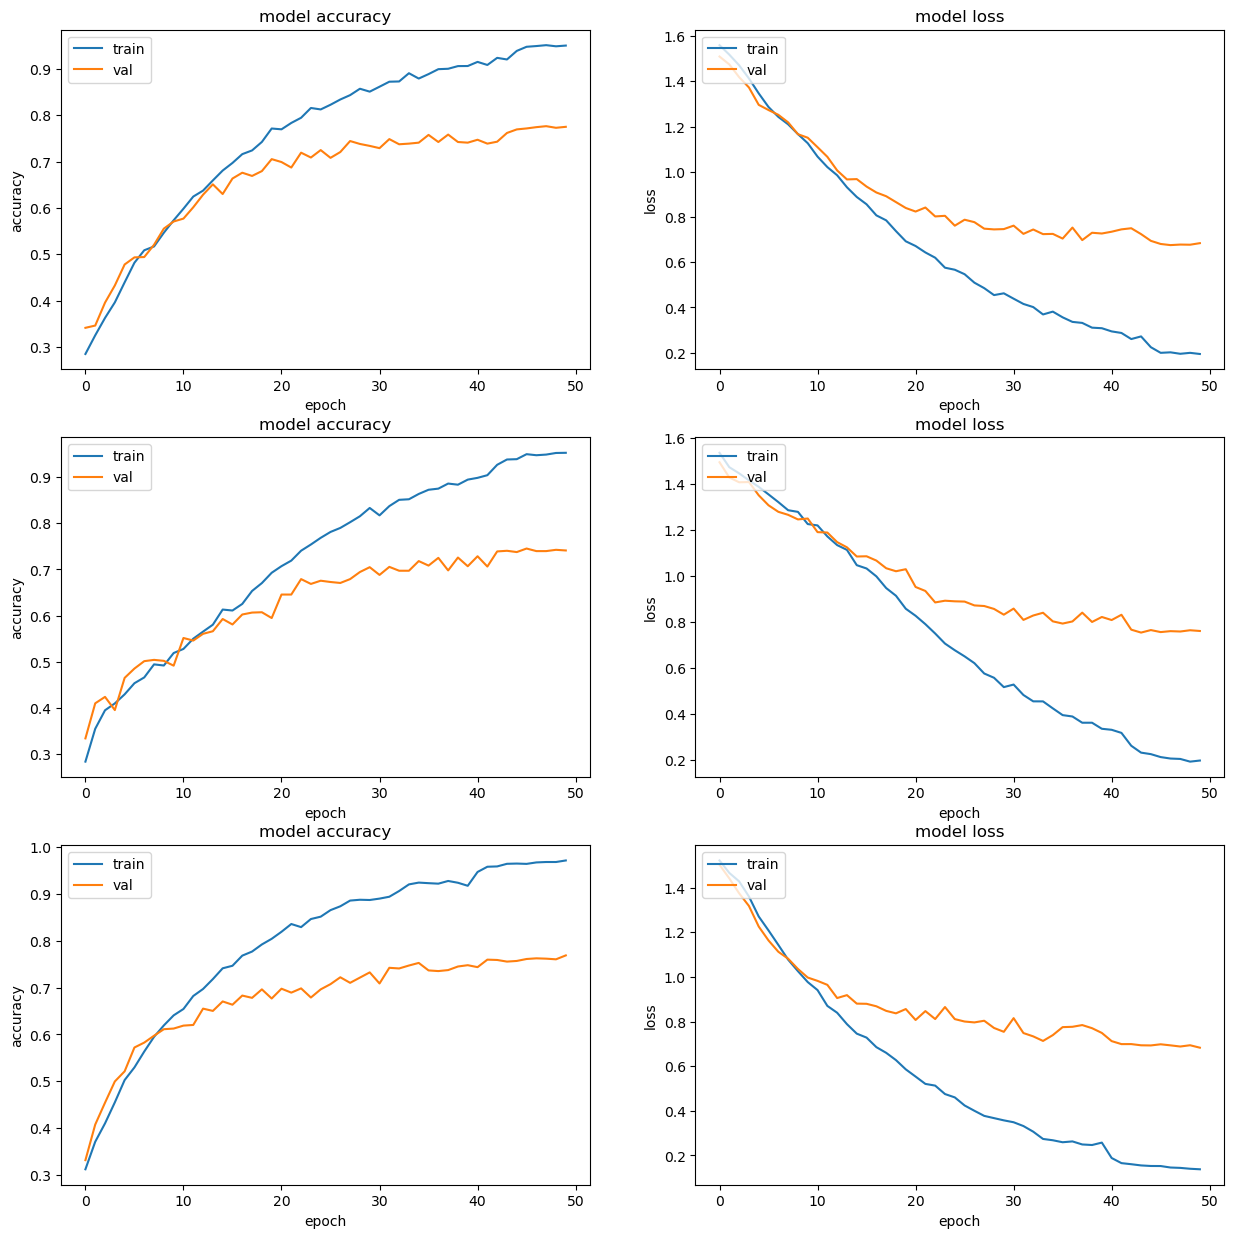


m2
emodb


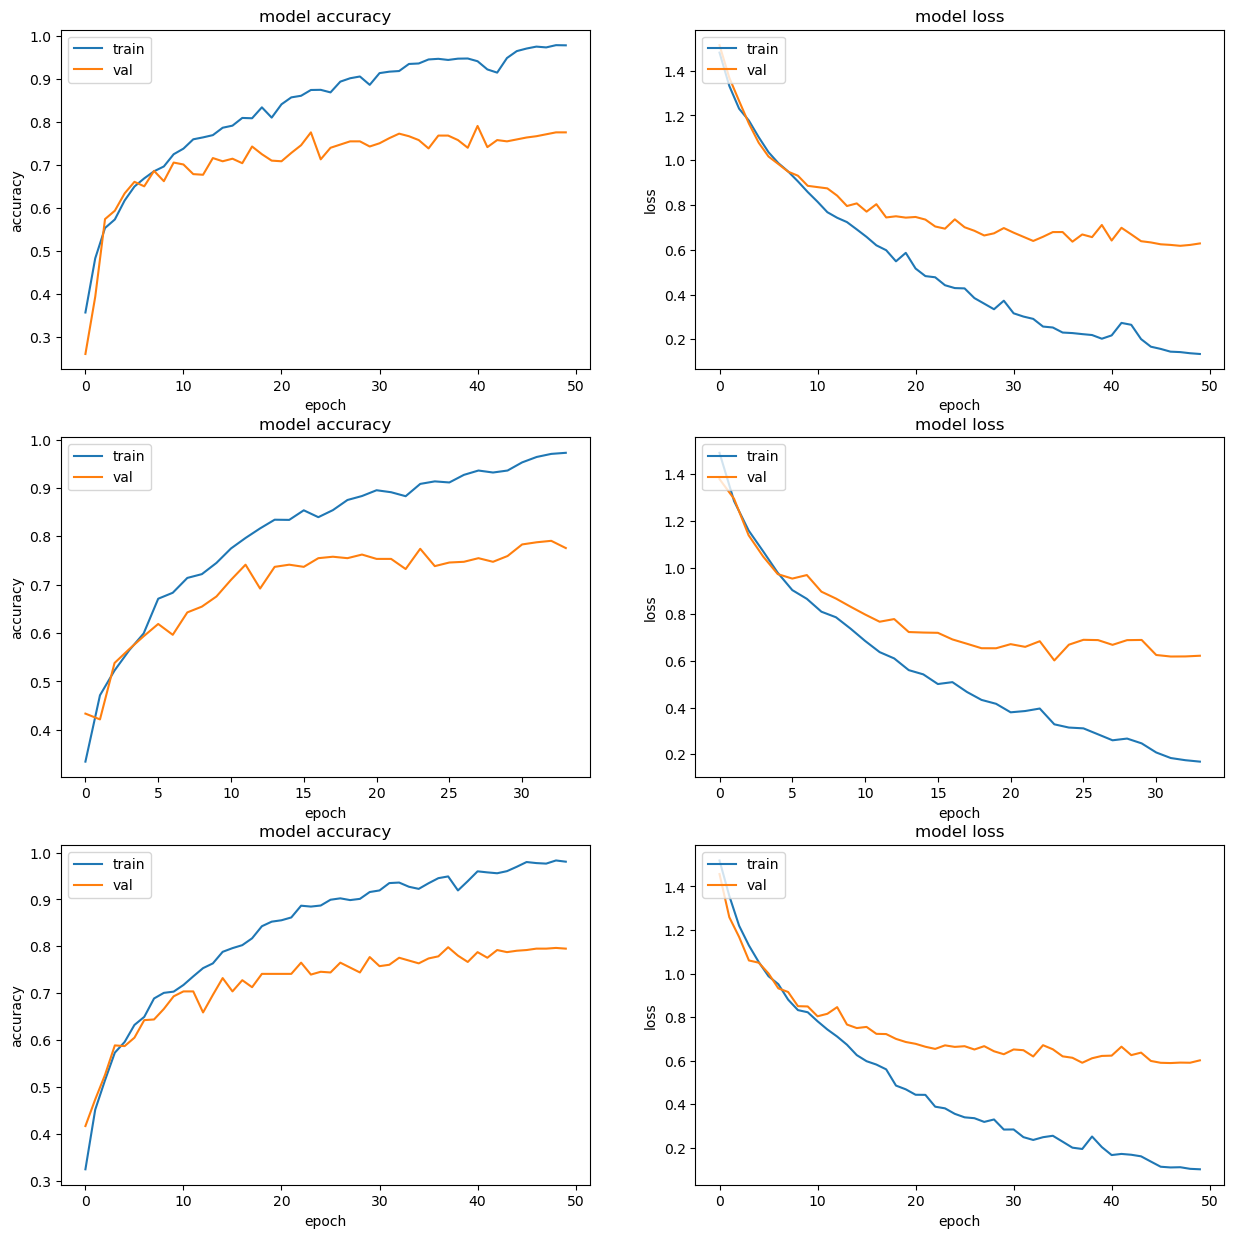

emovo


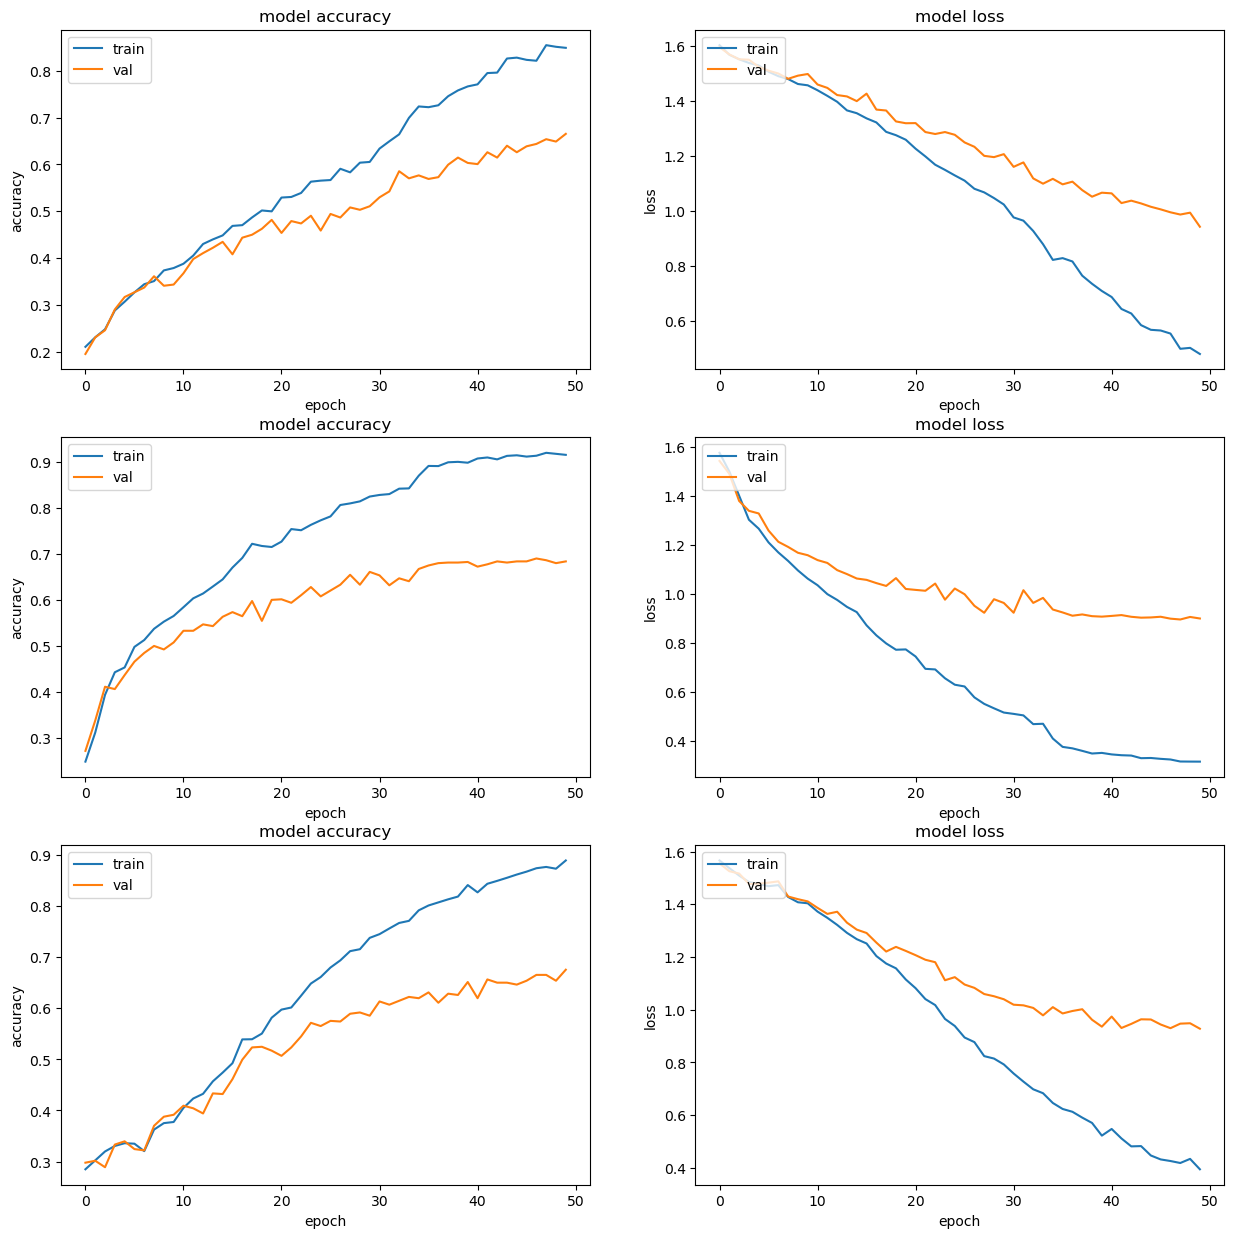

ravdess


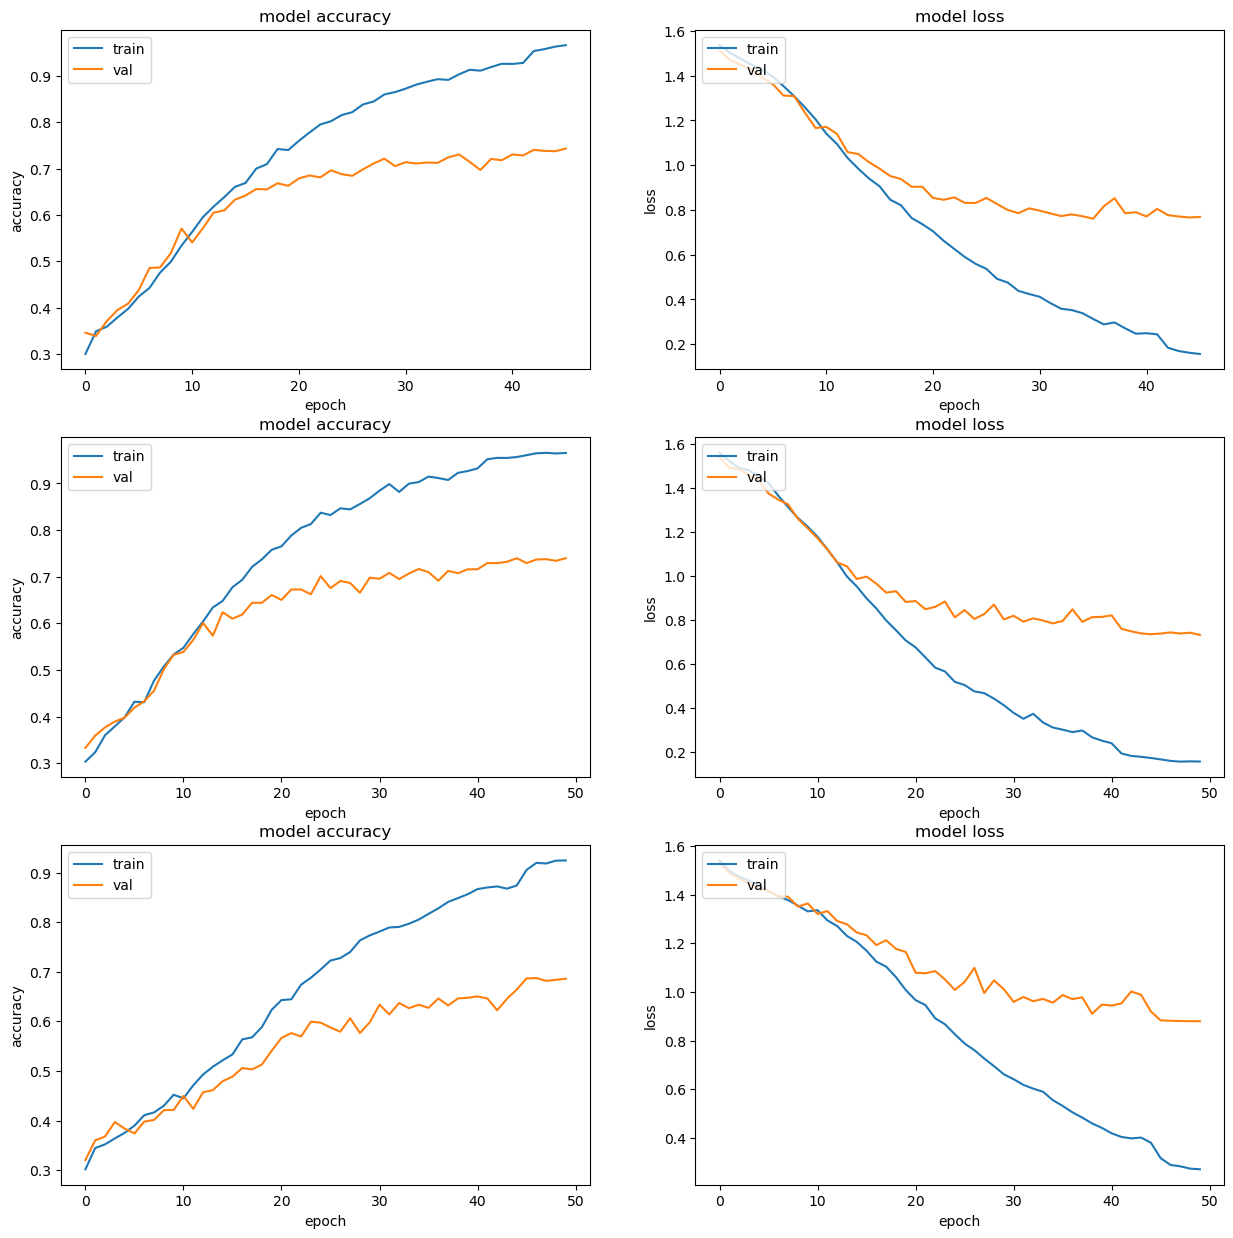


m3
emodb


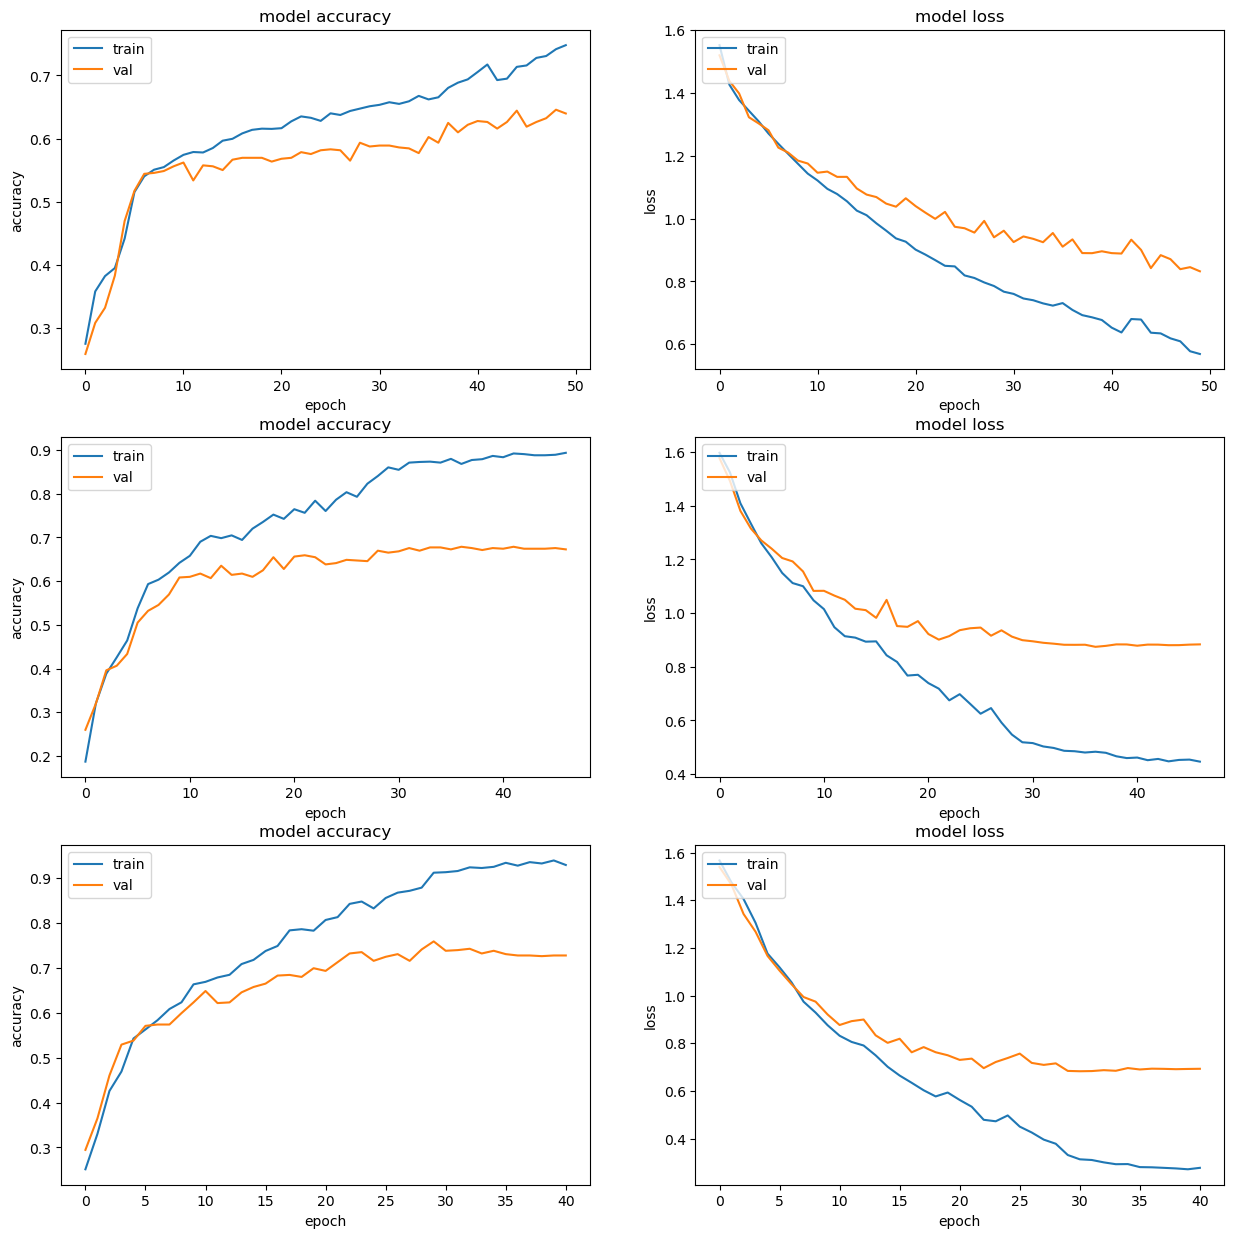

emovo


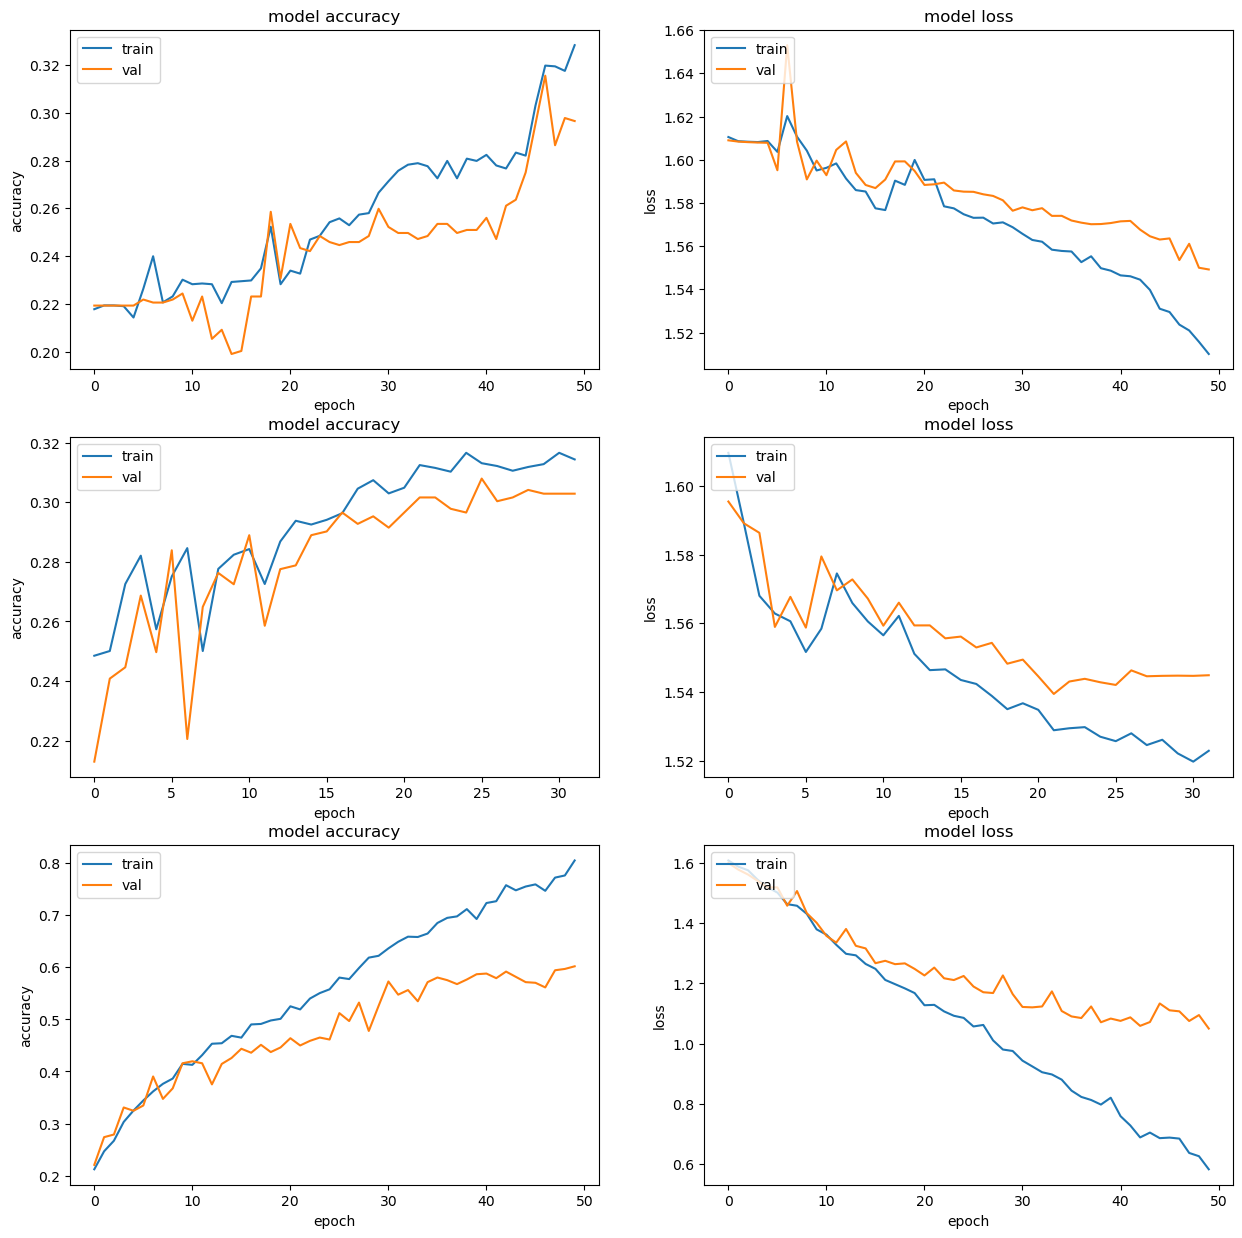

ravdess


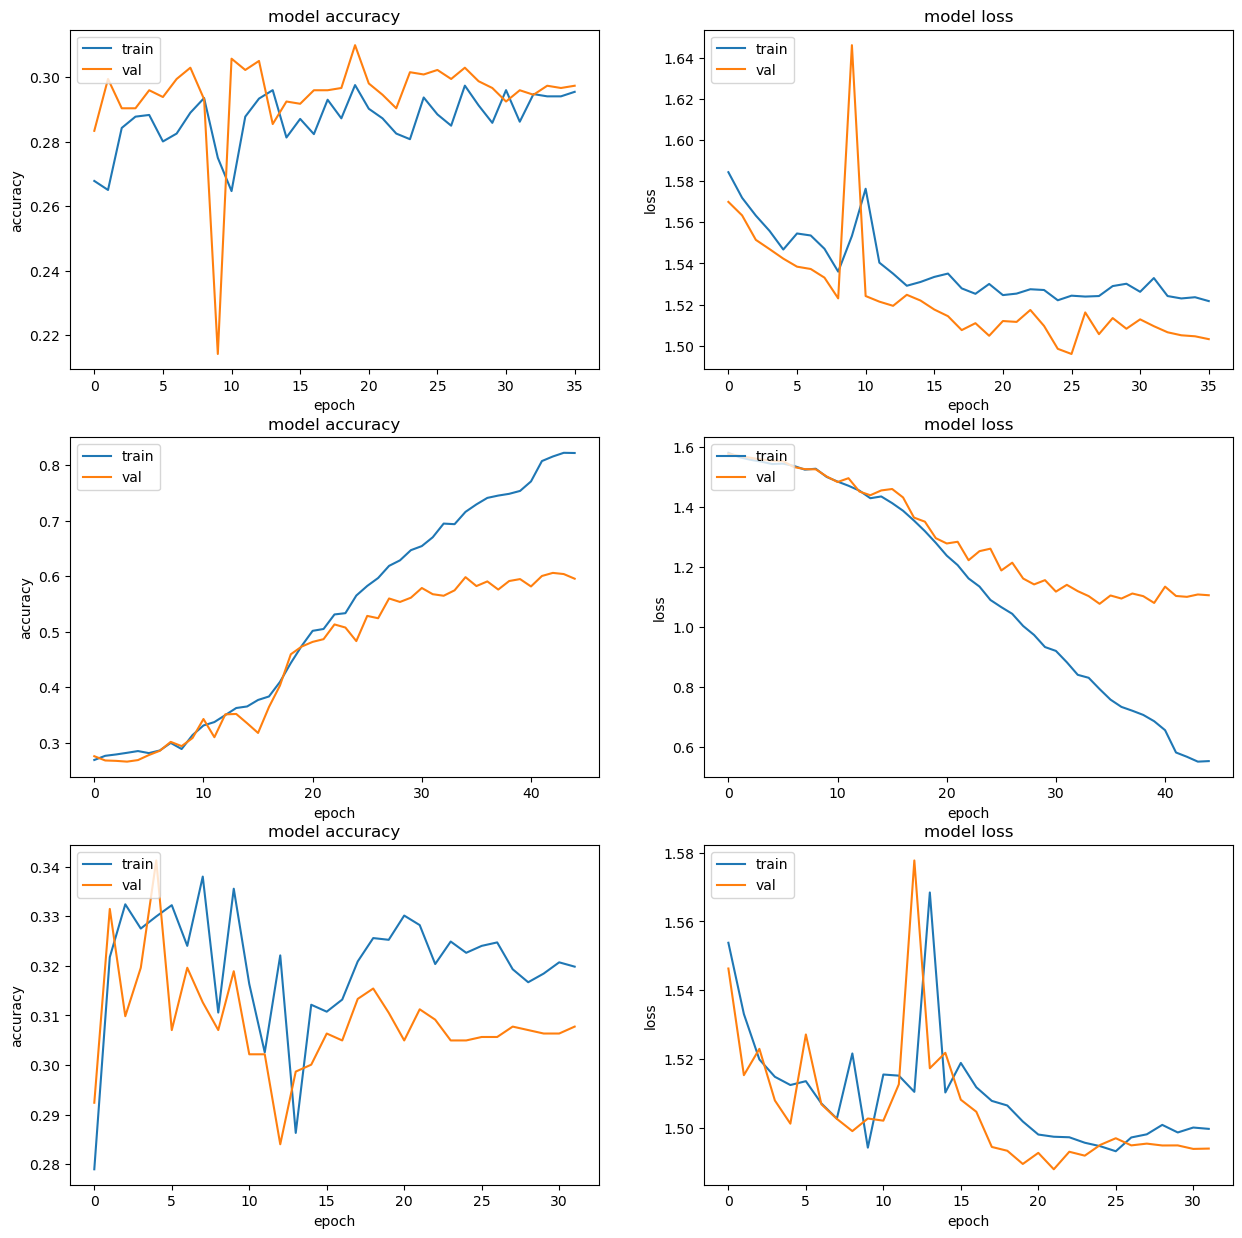


m4
emodb


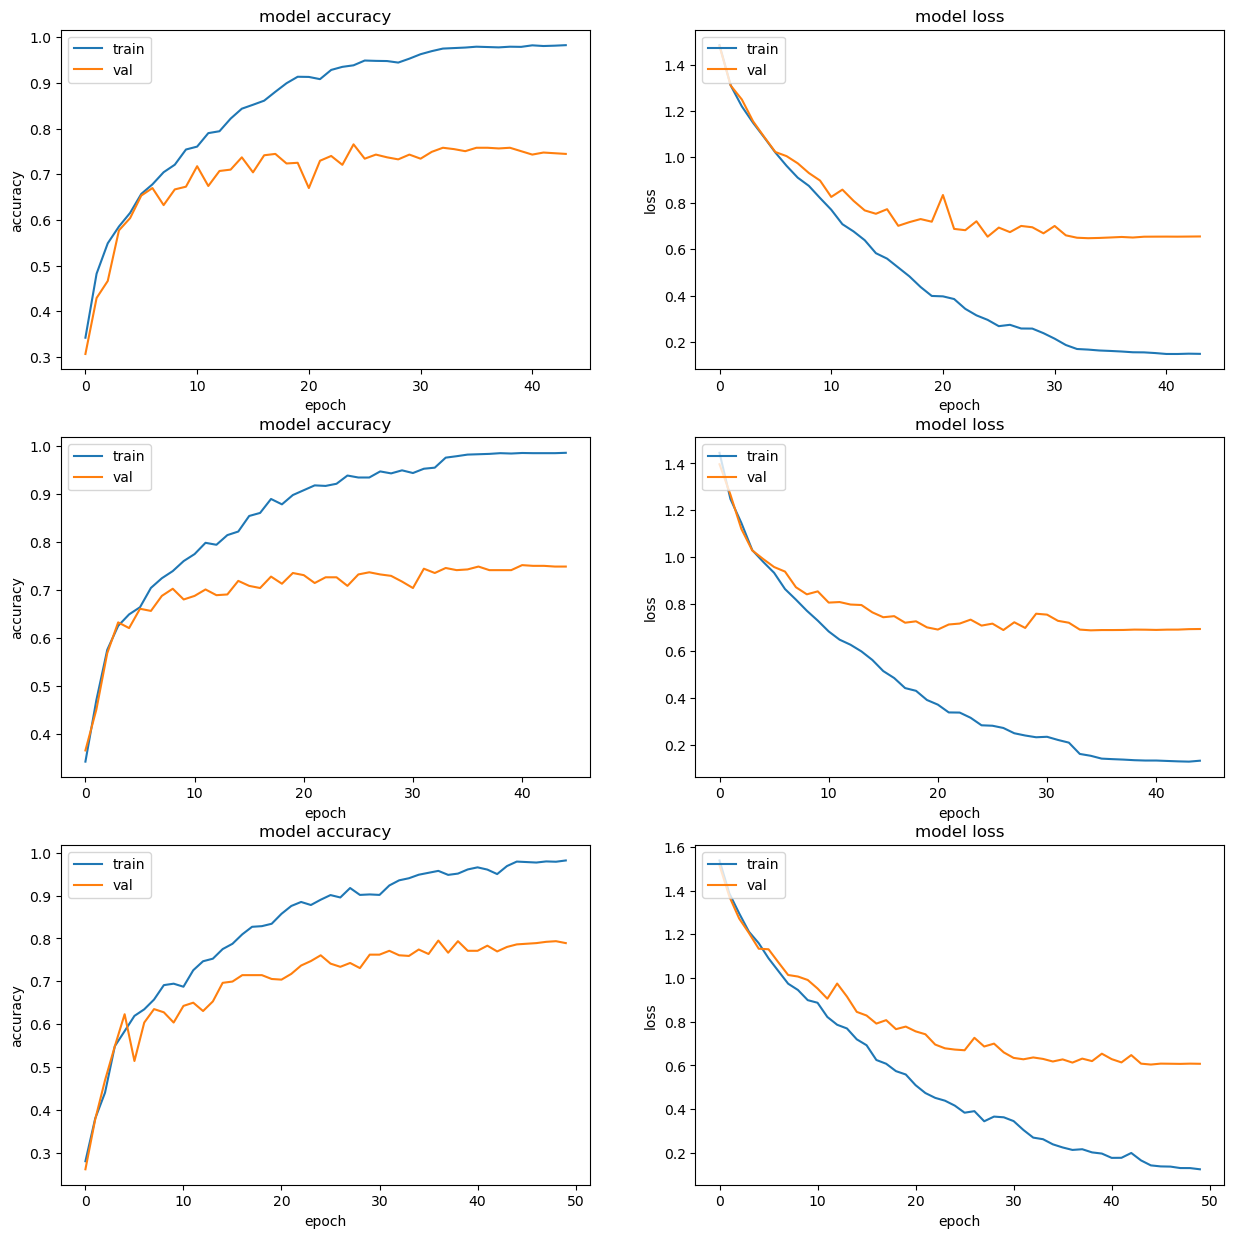

emovo


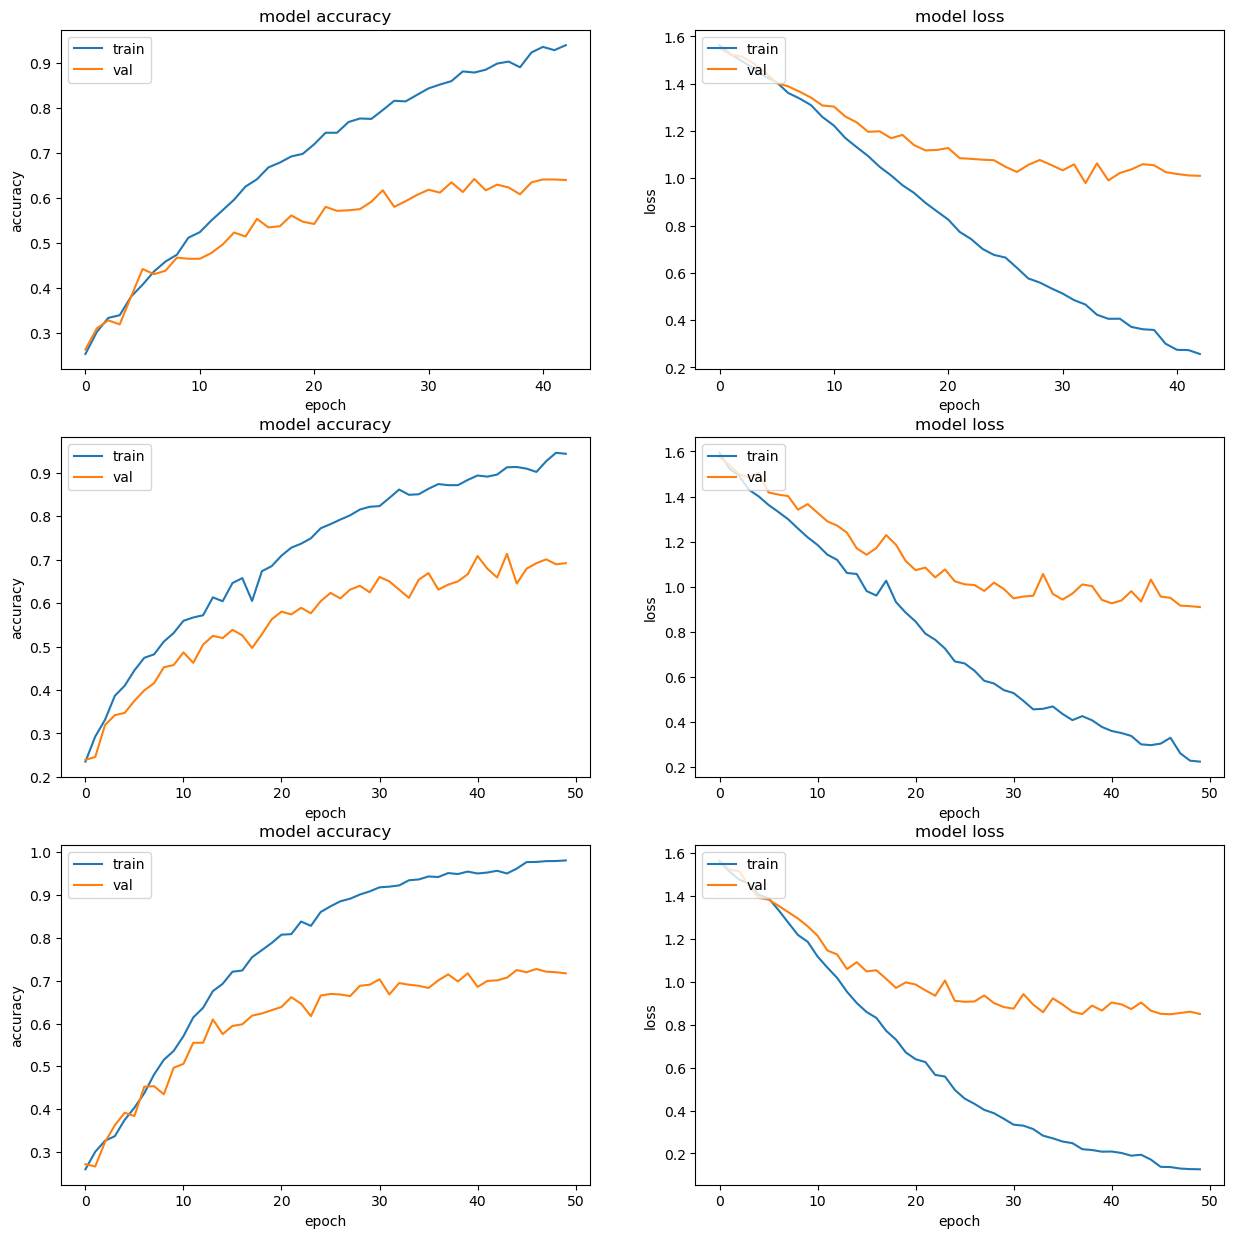

ravdess


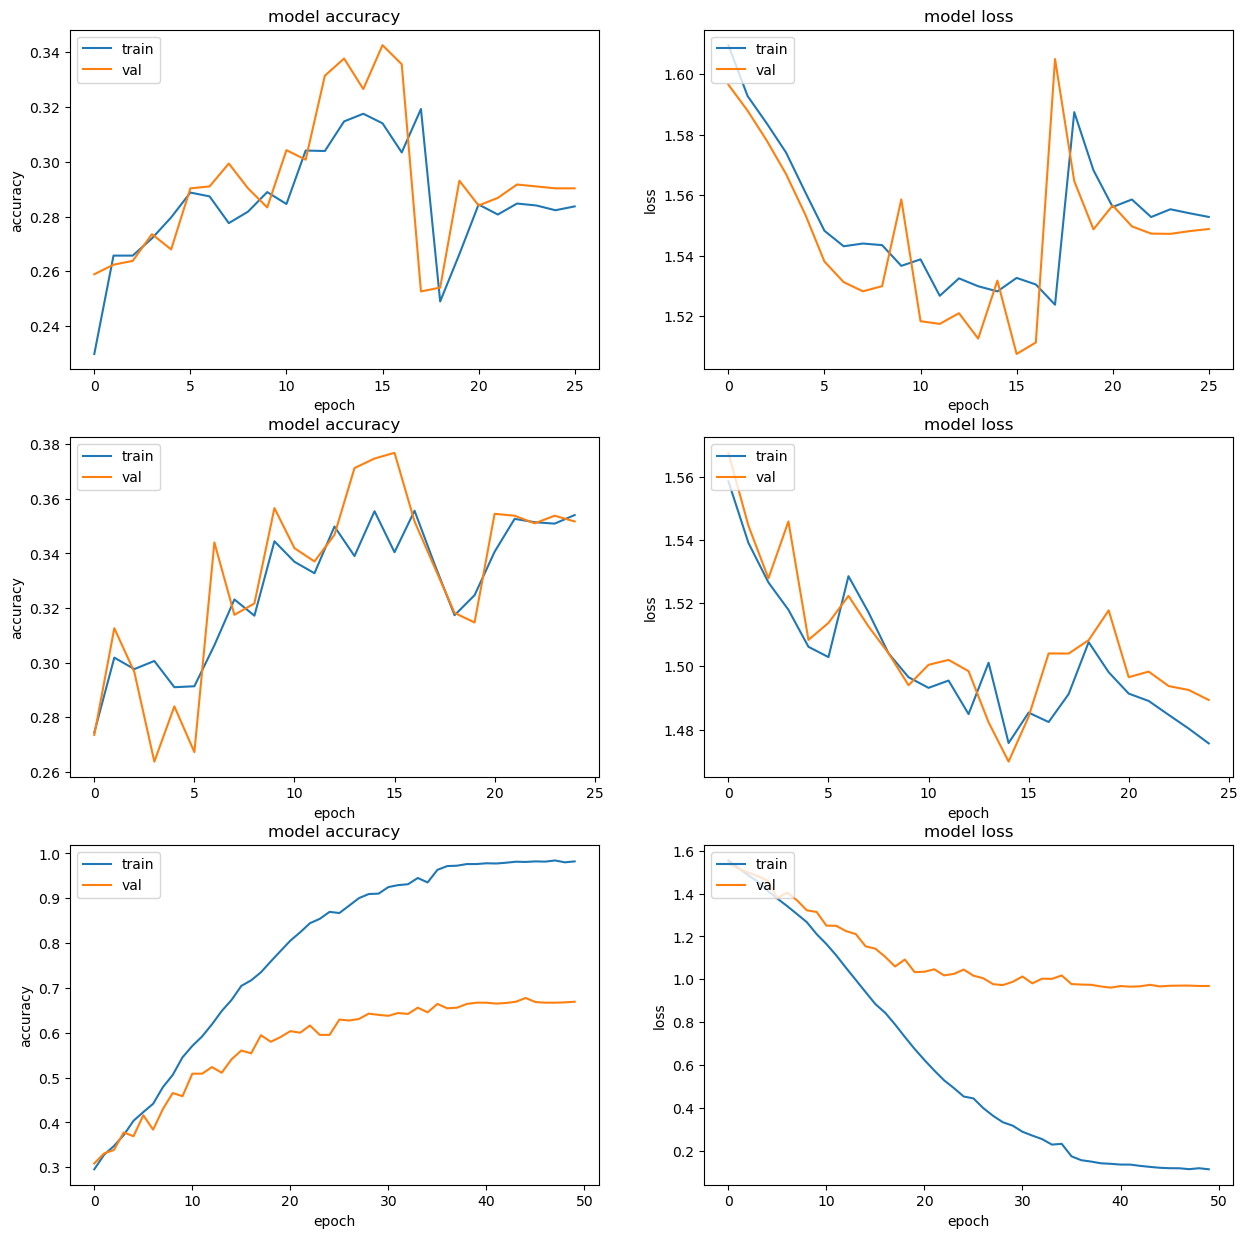


m5
emodb


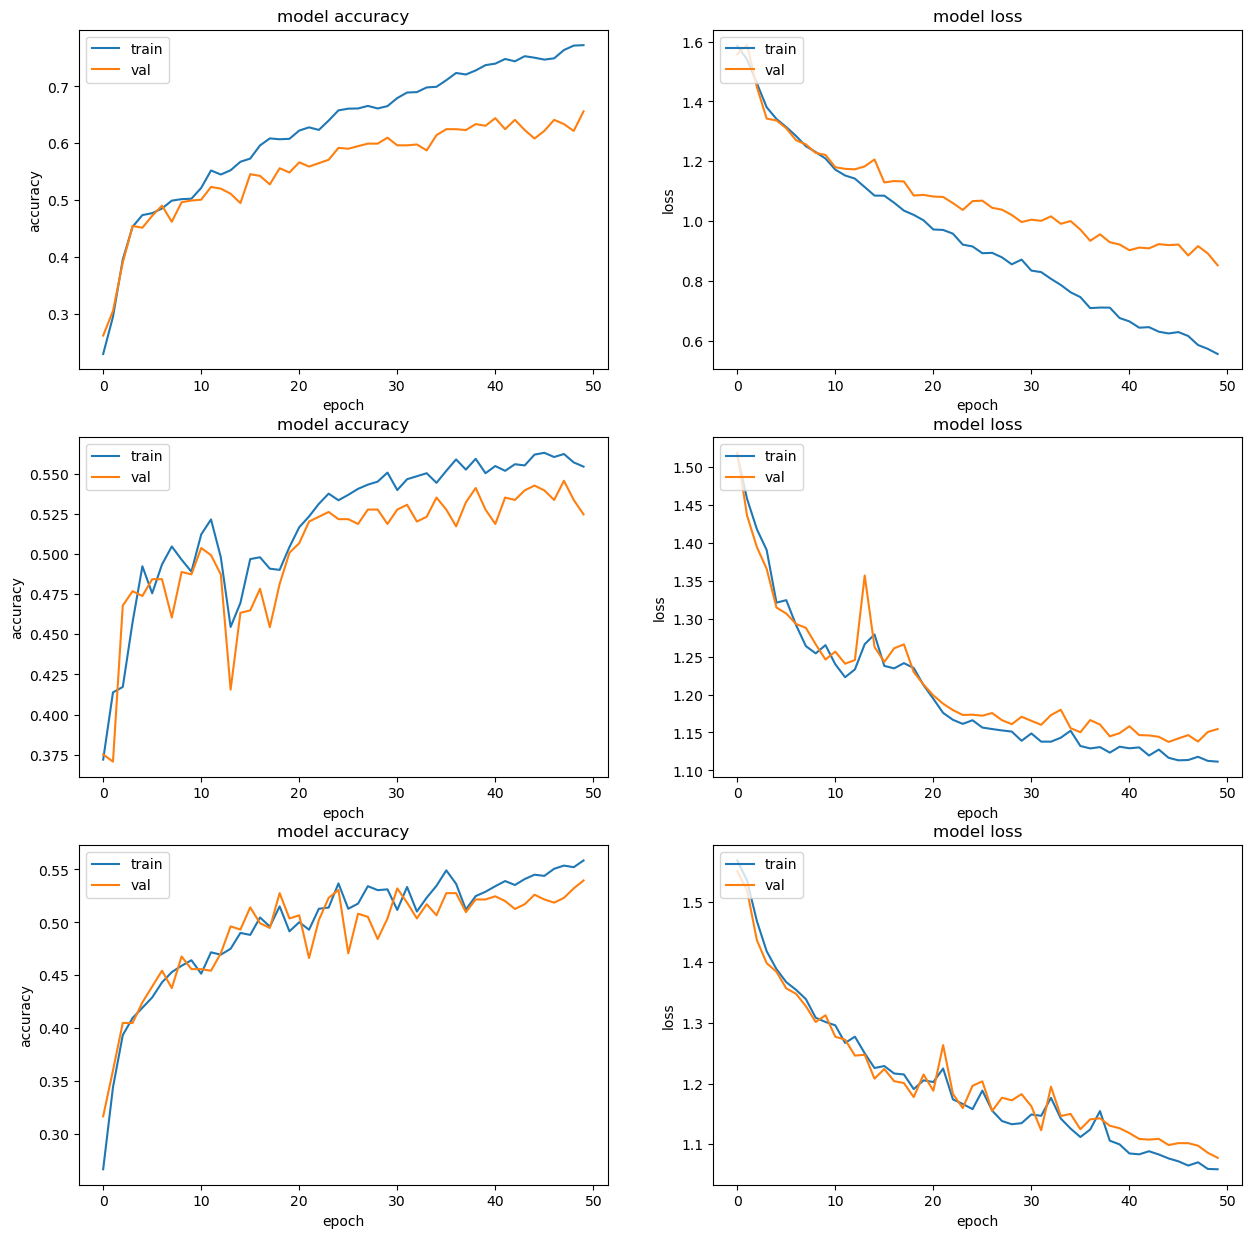

emovo


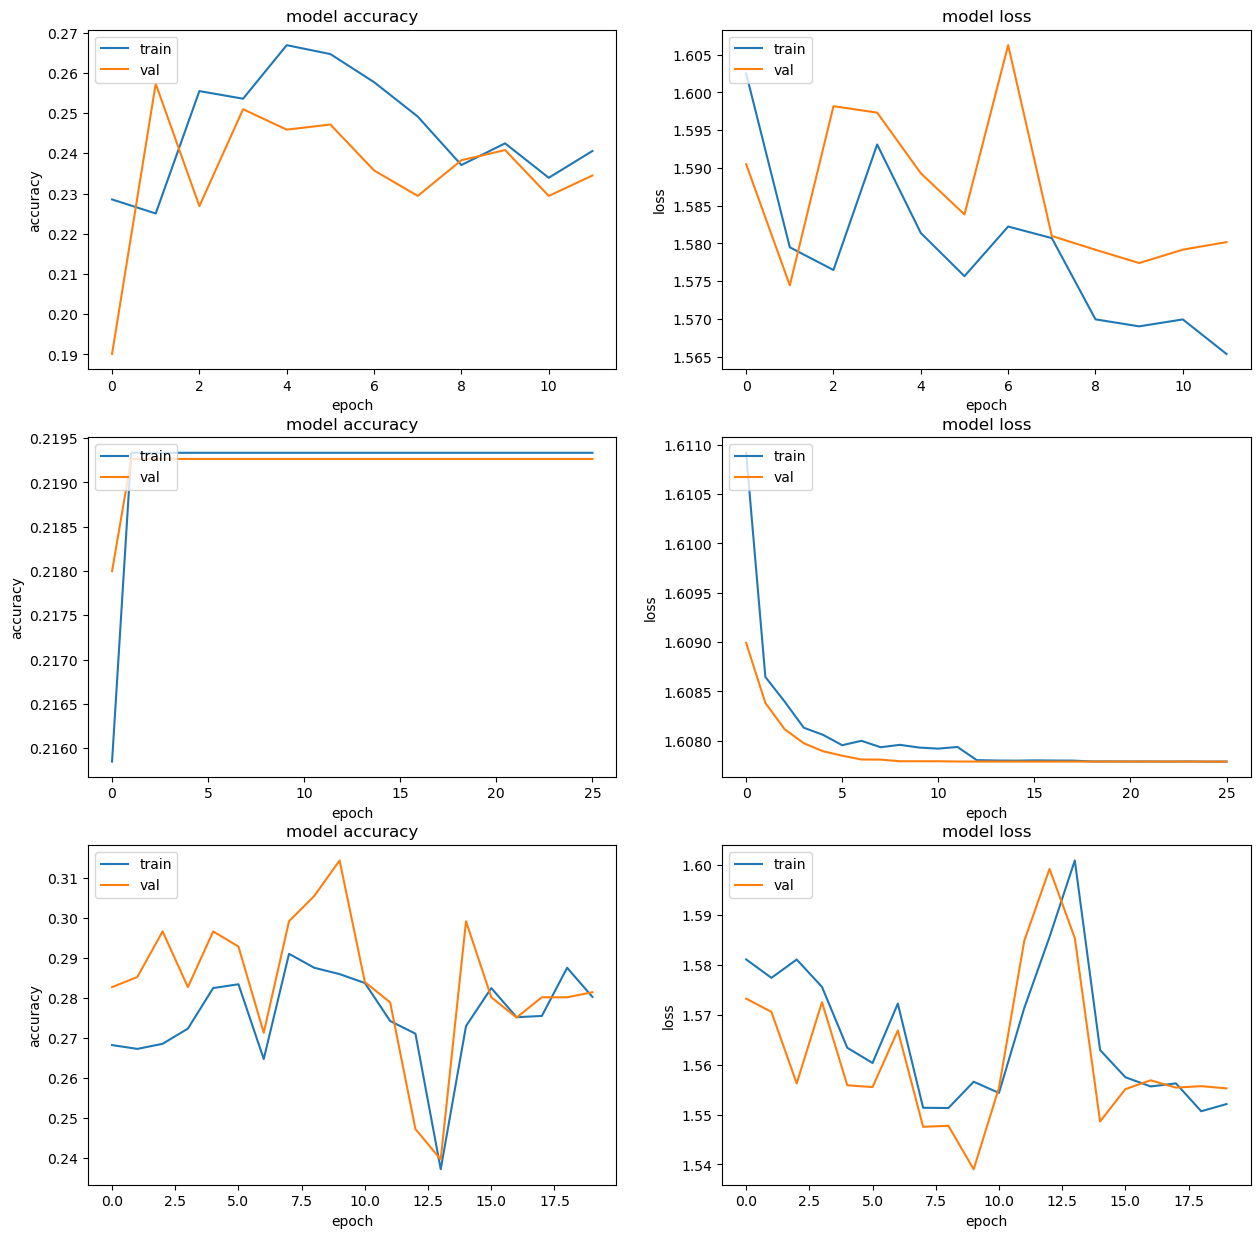

ravdess


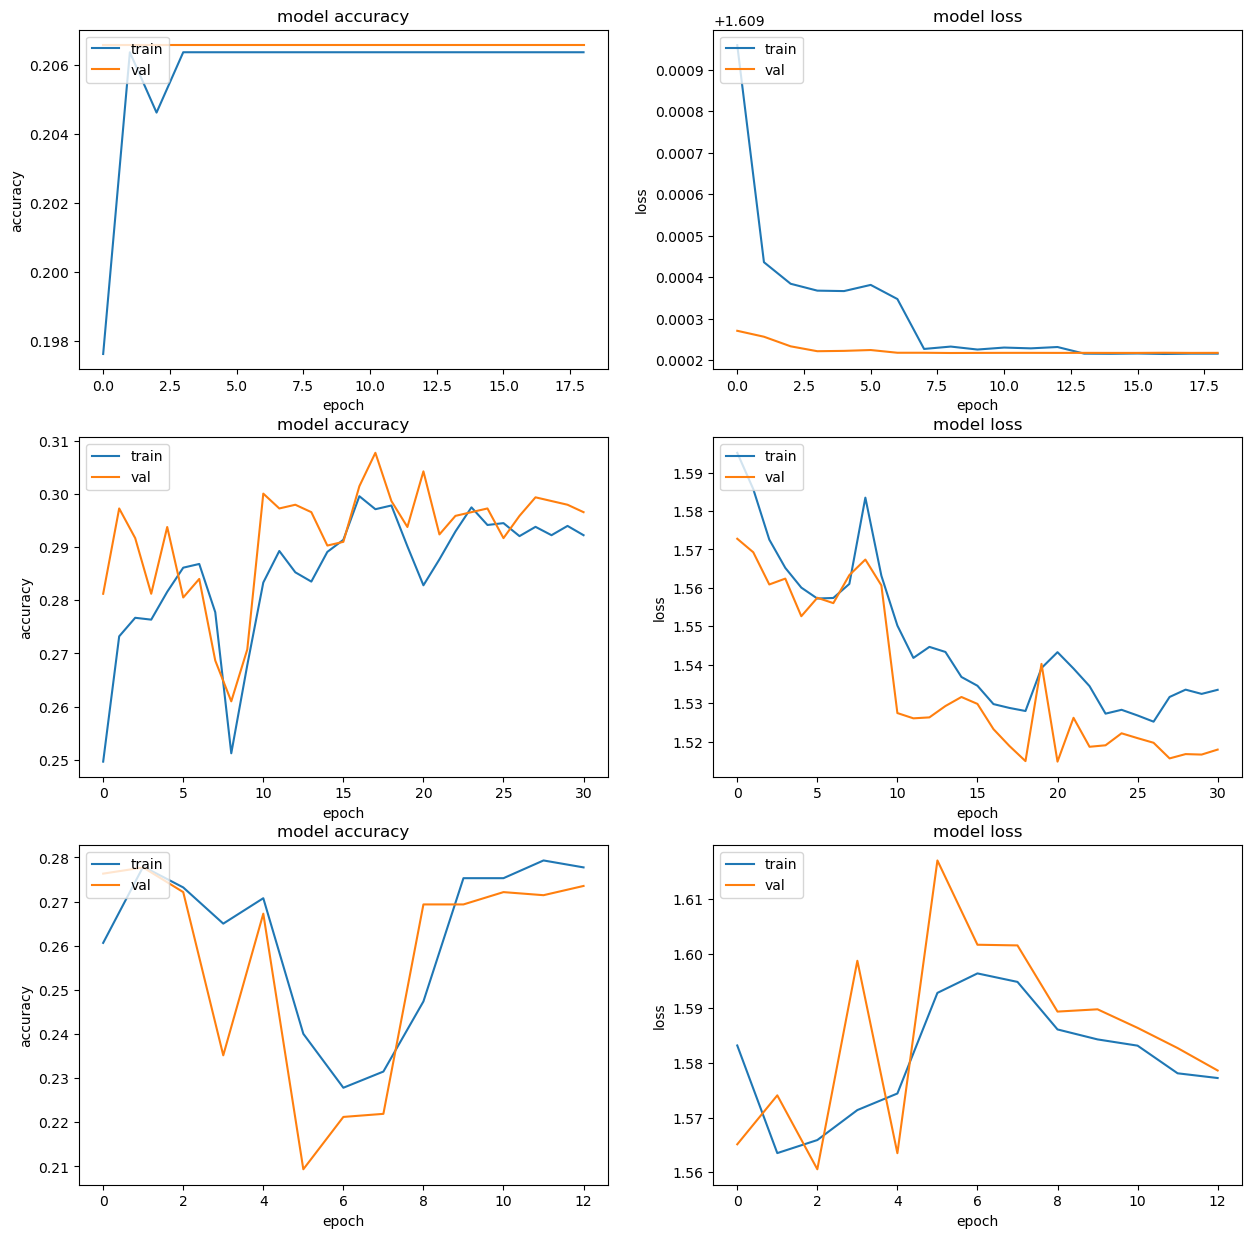


m6
emodb


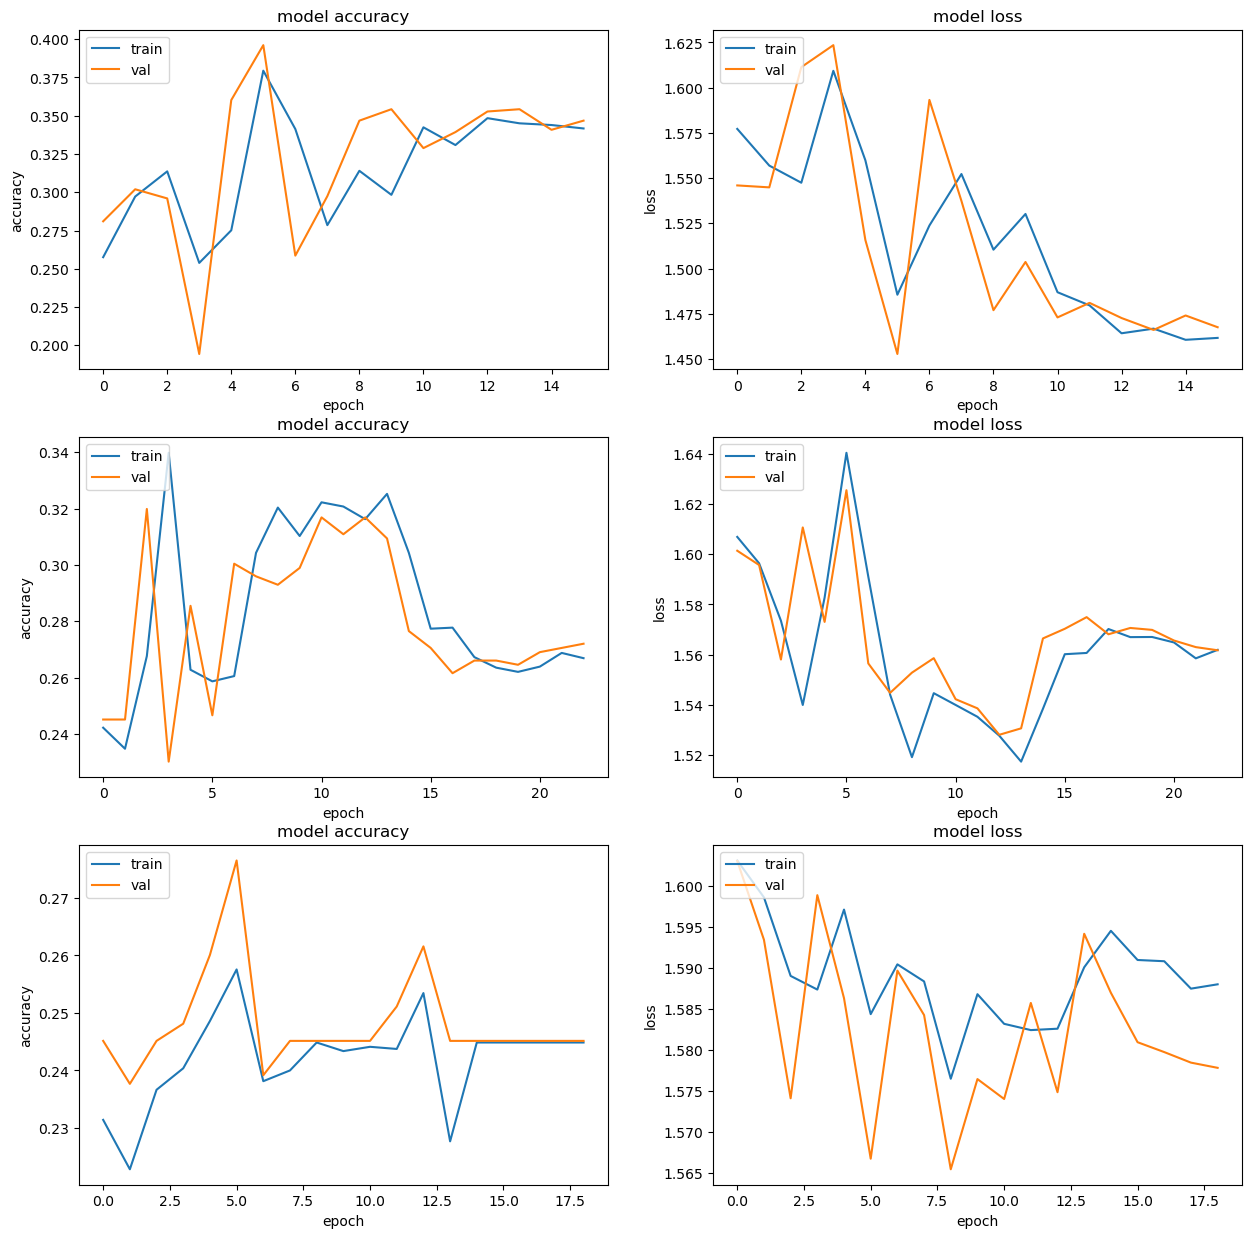

emovo


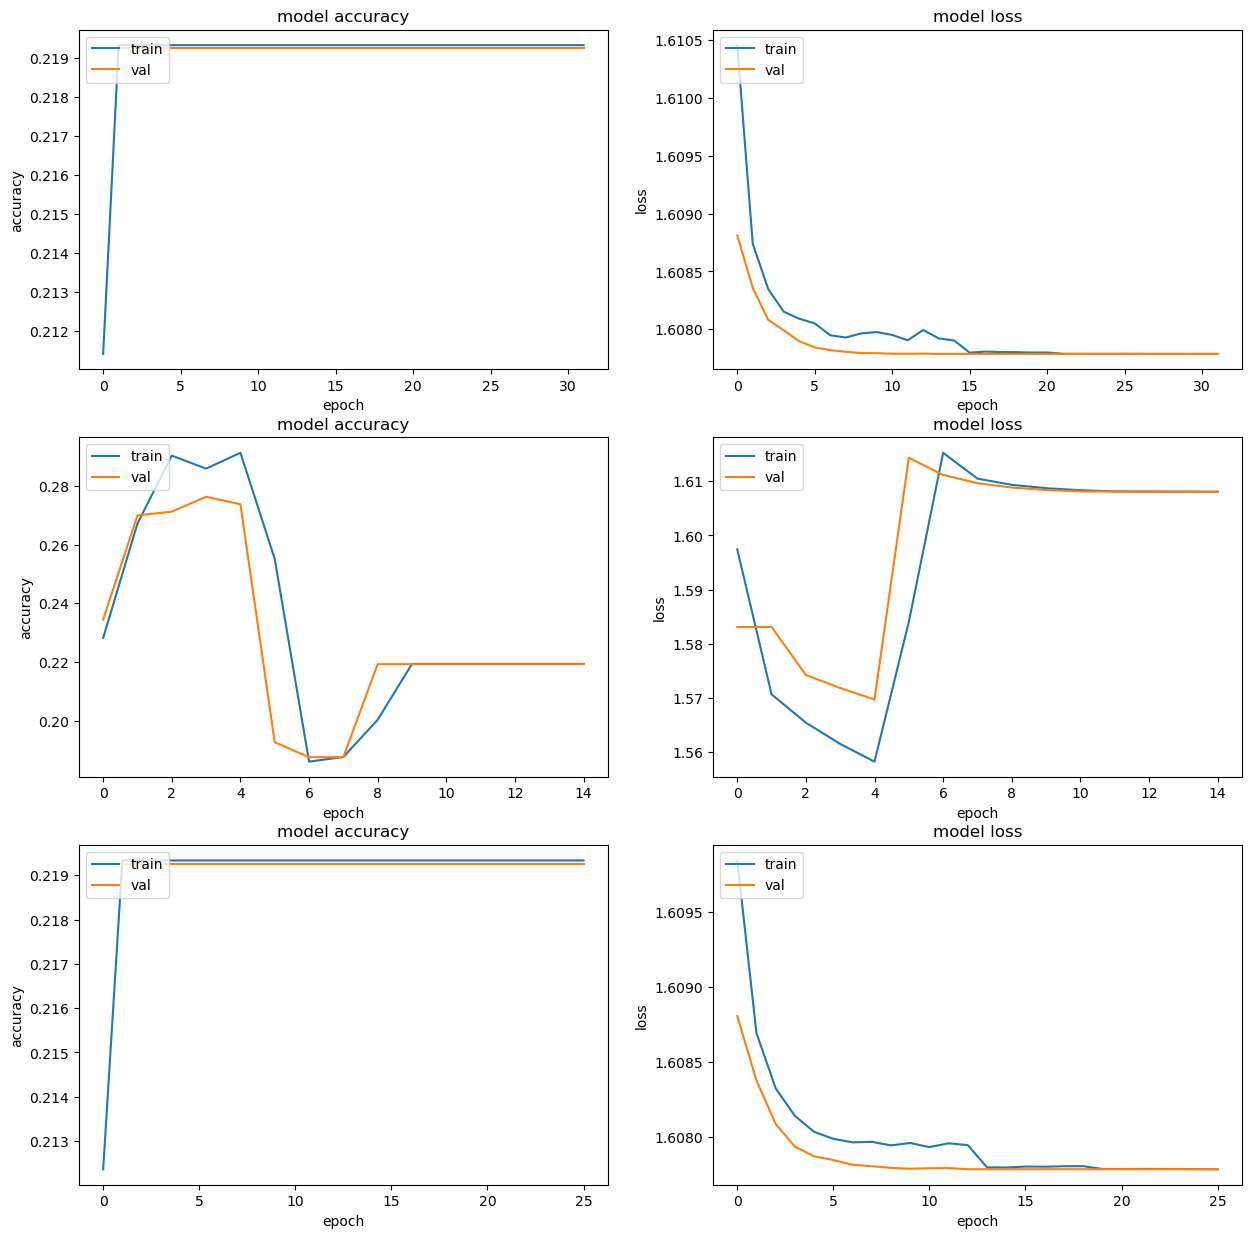

ravdess


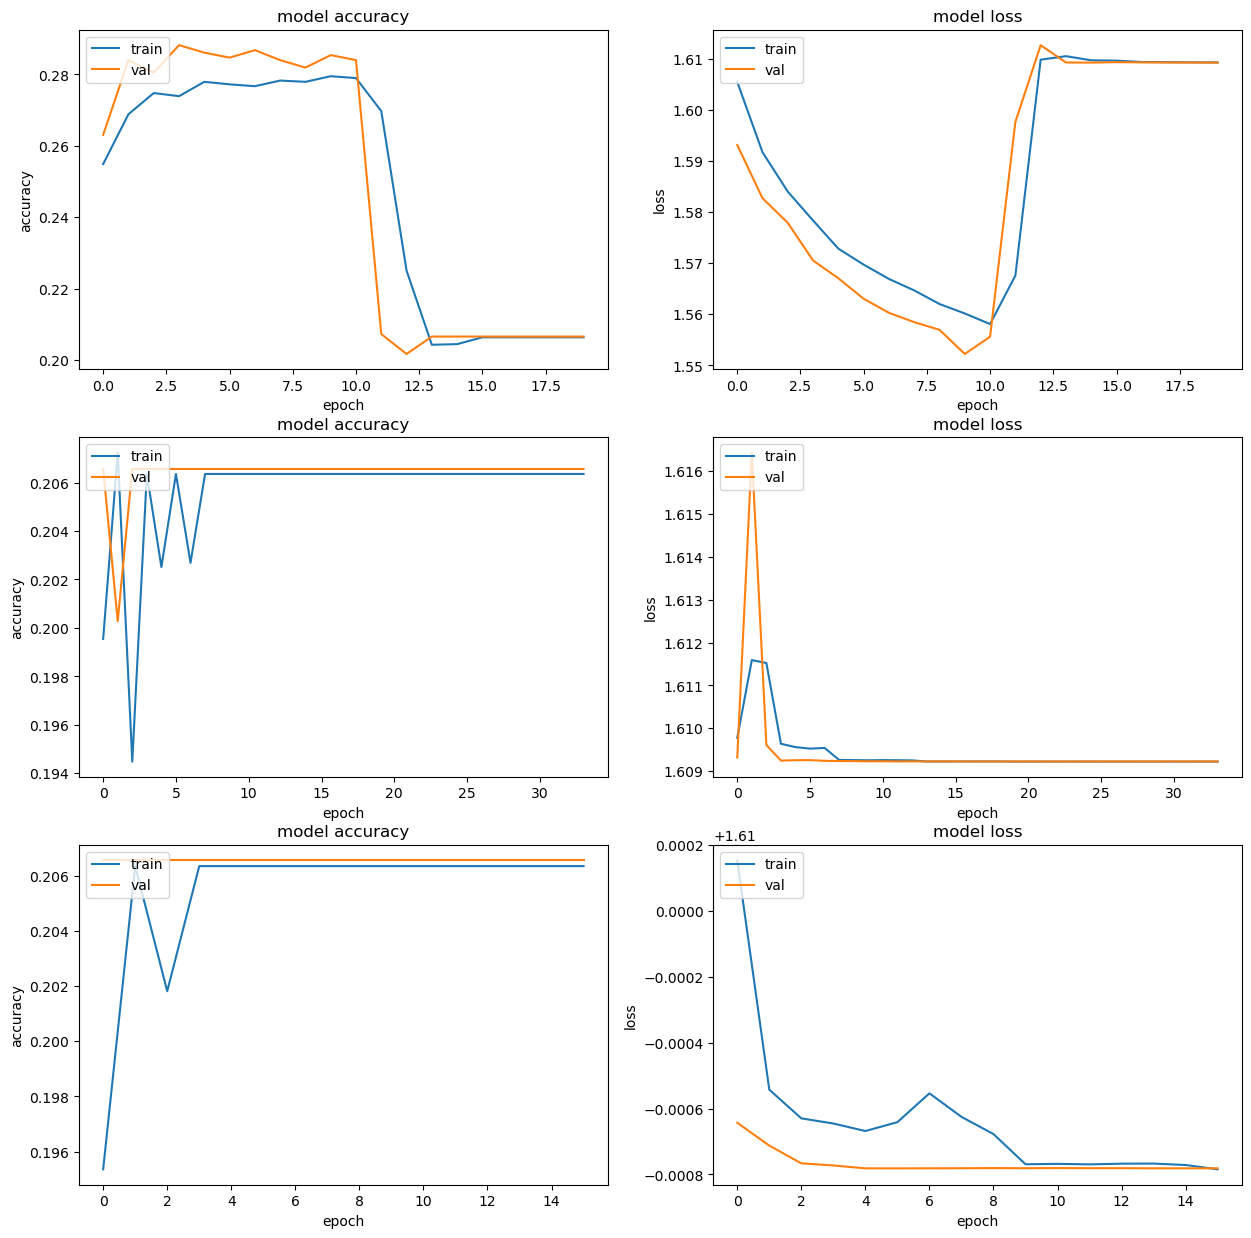

In [20]:
for s in results_arch:
    print(s)
    for d in results_arch[s]:
        print(d)
        plot_stats([p[0] for p in results_arch[s][d]])
    print()